
# Test Evaluation (Final)

Organized evaluation notebook with paired markdown/code cells. It loads offline/online results, builds unified solution tables, derives costs (travel vs lateral), computes competitive ratios (utility and costs), and prepares grouped views by risk level and budget.


## Setup and data sources

In [1]:

from pathlib import Path
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure repo root and src on path
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / 'src' / 'motion_planning').exists():
        REPO_ROOT = parent
        break
src_path = REPO_ROOT / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from motion_planning.utils.paths import OFFLINE_RESULTS_DIR, ONLINE_RESULTS_DIR, RESULTS_DIR
from motion_planning.evaluation.competitive_ratio import compute_competitive_ratio
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.online_algorithms.thresholds import czl_thresholds

print('Repo root:', REPO_ROOT)
print('Offline dir:', OFFLINE_RESULTS_DIR)
print('Online dir:', ONLINE_RESULTS_DIR)


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
Offline dir: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems
Online dir: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions


## Discover offline/online artifacts

In [2]:

# Offline
offline_graph = sorted((OFFLINE_RESULTS_DIR / 'solution details').glob('*_offline_graph_solution_edges.csv'))
offline_cand = sorted((OFFLINE_RESULTS_DIR / 'problem details').glob('*_offline_candidates_opt.csv'))

# Online
online_graph = sorted((ONLINE_RESULTS_DIR / 'graph-based').glob('*_online_ITM-ORB.csv'))
online_cand = sorted((ONLINE_RESULTS_DIR / 'candidates').glob('*_online_*ORB.csv'))

print(f'Counts -> offline graph: {len(offline_graph)}, offline cand: {len(offline_cand)}')
print(f'Counts -> online graph: {len(online_graph)}, online cand: {len(onine_cand) if "onine_cand" in locals() else len(online_cand)}')


Counts -> offline graph: 1920, offline cand: 1920
Counts -> online graph: 1920, online cand: 3840


## Helper functions (meta parsing, ingestion, derived costs)

In [3]:

risk_labels = {'low', 'mid', 'medium', 'high', 'very_high', 'veryhigh', 'very'}


def parse_meta(stem: str):
    parts = stem.split('_')
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None, None
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
    scenario = '_'.join(scen_parts) or stem
    risk_label = parts[risk_idx]
    return scenario, budget, risk_label


def _parse_coord(node):
    parts = str(node).split('_')
    if len(parts) < 3:
        return None, None
    try:
        x, y = float(parts[-2]), float(parts[-1])
        return x, y
    except Exception:
        return None, None


def _lateral_from_path_nodes(path_nodes_str: str):
    tokens = [p.strip() for p in str(path_nodes_str).split('>') if p.strip()]
    if len(tokens) < 2:
        return 0.0
    total = 0.0
    for a, b in zip(tokens, tokens[1:]):
        _, y1 = _parse_coord(a)
        _, y2 = _parse_coord(b)
        if y1 is None or y2 is None:
            continue
        total += abs(y2 - y1)
    return total


def derive_lateral_travel(df, total_cost: float):
    lateral_sum = 0.0
    lateral_found = False

    if {'start_node', 'end_node'}.issubset(df.columns):
        for a, b in zip(df['start_node'], df['end_node']):
            _, y1 = _parse_coord(a)
            _, y2 = _parse_coord(b)
            if y1 is None or y2 is None:
                continue
            lateral_sum += abs(y2 - y1)
            lateral_found = True
    elif 'path_nodes' in df.columns:
        for path_nodes_str in df['path_nodes']:
            lateral_sum += _lateral_from_path_nodes(path_nodes_str)
            lateral_found = True

    lateral_cost = float(lateral_sum * 10) if lateral_found else None
    travel_cost = None
    if total_cost is not None and not pd.isna(total_cost) and lateral_cost is not None:
        travel_cost = float(total_cost - lateral_cost)
    return lateral_cost, travel_cost


def extract_solution(df: pd.DataFrame):
    sol = {}
    for col in ('risk', 'cost', 'utility'):
        if col in df.columns:
            series = pd.to_numeric(df[col], errors='coerce')
            sol[f'{col}s'] = series.tolist()
            sol[f'total_{col}'] = float(series.sum())
        else:
            sol[f'{col}s'] = None
            sol[f'total_{col}'] = None

    if {'start_node', 'end_node'}.issubset(df.columns):
        sol['edges'] = list(zip(df['start_node'].astype(str), df['end_node'].astype(str)))
        sol['nodes'] = list(pd.unique(df[['start_node', 'end_node']].astype(str).values.ravel('K')))
    elif 'path_nodes' in df.columns:
        node_lists = []
        for path_nodes_str in df['path_nodes']:
            tokens = [p.strip() for p in str(path_nodes_str).split('>') if p.strip()]
            if tokens:
                node_lists.append(tokens)
        flat_nodes = {n for nodes in node_lists for n in nodes}
        sol['nodes'] = list(flat_nodes) if flat_nodes else None
    else:
        sol['nodes'] = None

    if 'speed' in df.columns:
        sol['speeds'] = df['speed'].tolist()
    elif 'path_speeds' in df.columns:
        sol['speeds'] = df['path_speeds'].tolist()
    else:
        sol['speeds'] = None

    lateral_cost, travel_cost = derive_lateral_travel(df, sol.get('total_cost'))
    sol['lateral_cost'] = lateral_cost
    sol['travel_cost'] = travel_cost
    return sol


def ingest(path: Path):
    if path is None:
        return None
    df = pd.read_csv(path)
    payload = extract_solution(df)
    payload['file'] = path.name
    payload['risk_budget'] = _parse_risk_budget_from_stem(path)
    scen, budget, risk_label = parse_meta(path.stem)
    payload['scenario_name'] = scen
    payload['budget'] = budget
    payload['risk_label'] = risk_label
    return payload


## Build unified solutions DataFrame

In [4]:

base = lambda path, suffix: path.stem.replace(suffix, '')

offline_graph_map = {base(p, '_offline_graph_solution_edges'): p for p in offline_graph}
offline_cand_map = {base(p, '_offline_candidates_opt'): p for p in offline_cand}

online_czl_map, online_bat_map = {}, {}
for p in online_cand:
    stem = p.stem
    scen, alg = stem.split('_online_', 1) if '_online_' in stem else (stem, 'unknown')
    alg_key = alg.lower()
    if 'czl' in alg_key:
        online_czl_map[scen] = p
    elif 'bat' in alg_key:
        online_bat_map[scen] = p

online_itm_map = {base(p, '_online_ITM-ORB'): p for p in online_graph}

all_bases = sorted(set().union(offline_graph_map, offline_cand_map, online_czl_map, online_bat_map, online_itm_map))
rows = []
for scen in all_bases:
    rows.append({
        'scenario': scen,
        'offline_graph': ingest(offline_graph_map.get(scen)),
        'offline_cand': ingest(offline_cand_map.get(scen)),
        'online_czl': ingest(online_czl_map.get(scen)),
        'online_bat': ingest(online_bat_map.get(scen)),
        'online_itm': ingest(online_itm_map.get(scen)),
    })

df_solutions = pd.json_normalize(rows, sep='.')
print('df_solutions shape:', df_solutions.shape)
display(df_solutions.head())


df_solutions shape: (1920, 78)


scenario  \
0       iter10_Town01_T-Intersection_10_high_5   
1        iter10_Town01_T-Intersection_10_low_5   
2     iter10_Town01_T-Intersection_10_medium_5   
3  iter10_Town01_T-Intersection_10_very_high_5   
4       iter10_Town01_T-Intersection_15_high_5   

                                 offline_graph.risks  \
0  [0.4158125360615002, 0.001, 0.6761940258544497...   
1  [0.700209075627673, 0.001, 0.001, 0.2770484920...   
2  [0.1798037964624866, 0.001, 0.8757250264046885...   
3  [0.7583202838209272, 0.1323700435384928, 0.001...   
4  [0.5463407655938338, 0.4823192526841303, 0.438...   

   offline_graph.total_risk  \
0                  9.056297   
1                  3.656716   
2                  6.200755   
3                  9.592303   
4                  6.406851   

                                 offline_graph.costs  \
0  [61.200000003928736, 1.2000000040738328, 1.200...   
1  [61.200000003928736, 1.2000000040738328, 1.200...   
2  [61.200000003928736, 1.2000000040738328, 1.200...   
3  [51.20844978457892, 1.1999981730191585, 11.208...   
4  [61.200000003928736, 1.2000000040738328, 1.200...   

   offline_graph.total_cost  \
0                135.023058   
1                134.955823   
2                134.955823   
3                134.972719   
4                134.955823   

                              offline_graph.utilitys  \
0  [38.799999996071264, 98.79999999592616, 98.799...   
1  [38.799999996071264, 98.79999999592616, 98.799...   
2  [38.799999996071264, 98.79999999592616, 98.799...   
3  [48.79155021542108, 98.80000182698085, 88.7915...   
4  [38.799999996071264, 98.79999999592616, 98.799...   

   offline_graph.total_utility  \
0                  1964.976942   
1                  1965.044177   
2                  1965.044177   
3                  1965.027281   
4                  1965.044177   

                                 offline_graph.edges  \
0  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
1  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
2  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
3  [(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_6...   
4  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   

                                 offline_graph.nodes  \
0  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
1  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
2  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
3  [v_0_0, v_1_5, v_2_5, v_3_6, v_4_6, v_5_6, v_6...   
4  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   

                                offline_graph.speeds  ...  \
0  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
1  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
2  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
3  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
4  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   

                                    online_itm.edges  \
0  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
1  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
2  [(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...   
3  [(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...   
4  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   

                                    online_itm.nodes  \
0  [v_0_0, v_1_6, v_2_6, v_3_6, v_10_6, v_4_6, v_...   
1  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
2  [v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
3  [v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
4  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   

                                   online_itm.speeds  online_itm.lateral_cost  \
0  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 2...                    110.0   
1  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...                    110.0   
2  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...                    110.0   
3  [30, 30, 30, 15, 30, 30, 30, 25, 30, 30, 30, 3...                    110.0   
4  [30, 30, 30, 30, 30, 30,

## Competitive ratios (utility, total cost, travel cost)

In [5]:


def _safe_cr(row, online_prefix: str, offline_prefix: str, objective: str):
    if objective in ('utility', 'cost'):
        online_val = row.get(f'{online_prefix}.total_{objective}')
        offline_val = row.get(f'{offline_prefix}.total_{objective}')
        obj = 'utility' if objective == 'utility' else 'cost'
    else:
        online_val = row.get(f'{online_prefix}.{objective}')
        offline_val = row.get(f'{offline_prefix}.{objective}')
        obj = 'cost'
    if online_val is None or offline_val is None:
        return None
    if pd.isna(online_val) or pd.isna(offline_val):
        return None
    return compute_competitive_ratio(
        online_value=float(online_val),
        offline_value=float(offline_val),
        objective=obj,
    )


df_cr = df_solutions.copy()

# Utility CRs vs offline opt (candidates and graph)
for alg in ['czl', 'bat', 'itm']:
    df_cr[f'cr_{alg}_opt_cand_utility'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_cand', 'utility'), axis=1)
    df_cr[f'cr_{alg}_opt_graph_utility'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_graph', 'utility'), axis=1)

# Total cost CRs
for alg in ['czl', 'bat', 'itm']:
    df_cr[f'cr_{alg}_opt_cand_cost'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_cand', 'cost'), axis=1)
    df_cr[f'cr_{alg}_opt_graph_cost'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_graph', 'cost'), axis=1)

# Travel-time cost CRs (using travel_cost derived)
for alg in ['czl', 'bat', 'itm']:
    df_cr[f'cr_{alg}_opt_cand_travel'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_cand', 'travel_cost'), axis=1)
    df_cr[f'cr_{alg}_opt_graph_travel'] = df_cr.apply(lambda r: _safe_cr(r, f'online_{alg}', 'offline_graph', 'travel_cost'), axis=1)

save_dir = RESULTS_DIR / 'evaluation'
save_dir.mkdir(parents=True, exist_ok=True)
cr_csv = save_dir / 'competitive_ratios_final.csv'
df_cr.to_csv(cr_csv, index=False)
print(f'Saved competitive ratios to {cr_csv}')
display(df_cr.head())


Saved competitive ratios to /home/abdulrahman/competitive-online-algorithms-motion-planning/results/evaluation/competitive_ratios_final.csv


scenario  \
0       iter10_Town01_T-Intersection_10_high_5   
1        iter10_Town01_T-Intersection_10_low_5   
2     iter10_Town01_T-Intersection_10_medium_5   
3  iter10_Town01_T-Intersection_10_very_high_5   
4       iter10_Town01_T-Intersection_15_high_5   

                                 offline_graph.risks  \
0  [0.4158125360615002, 0.001, 0.6761940258544497...   
1  [0.700209075627673, 0.001, 0.001, 0.2770484920...   
2  [0.1798037964624866, 0.001, 0.8757250264046885...   
3  [0.7583202838209272, 0.1323700435384928, 0.001...   
4  [0.5463407655938338, 0.4823192526841303, 0.438...   

   offline_graph.total_risk  \
0                  9.056297   
1                  3.656716   
2                  6.200755   
3                  9.592303   
4                  6.406851   

                                 offline_graph.costs  \
0  [61.200000003928736, 1.2000000040738328, 1.200...   
1  [61.200000003928736, 1.2000000040738328, 1.200...   
2  [61.200000003928736, 1.2000000040738328, 1.200...   
3  [51.20844978457892, 1.1999981730191585, 11.208...   
4  [61.200000003928736, 1.2000000040738328, 1.200...   

   offline_graph.total_cost  \
0                135.023058   
1                134.955823   
2                134.955823   
3                134.972719   
4                134.955823   

                              offline_graph.utilitys  \
0  [38.799999996071264, 98.79999999592616, 98.799...   
1  [38.799999996071264, 98.79999999592616, 98.799...   
2  [38.799999996071264, 98.79999999592616, 98.799...   
3  [48.79155021542108, 98.80000182698085, 88.7915...   
4  [38.799999996071264, 98.79999999592616, 98.799...   

   offline_graph.total_utility  \
0                  1964.976942   
1                  1965.044177   
2                  1965.044177   
3                  1965.027281   
4                  1965.044177   

                                 offline_graph.edges  \
0  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
1  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
2  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   
3  [(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_6...   
4  [(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...   

                                 offline_graph.nodes  \
0  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
1  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
2  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   
3  [v_0_0, v_1_5, v_2_5, v_3_6, v_4_6, v_5_6, v_6...   
4  [v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...   

                                offline_graph.speeds  ...  \
0  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
1  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
2  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
3  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   
4  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...  ...   

   cr_bat_opt_cand_cost  cr_bat_opt_graph_cost cr_itm_opt_cand_cost  \
0              1.170272               1.183086             1.009245   
1              1.000000               1.000000             1.000000   
2              1.015219               1.015219             1.000250   
3              1.326248               1.340397             1.001459   
4              1.000125               1.000125             1.000000   

   cr_itm_opt_graph_cost cr_czl_opt_cand_travel  cr_czl_opt_graph_travel  \
0               1.020295               1.122349                 1.188657   
1               1.000000               1.000000                 1.000000   
2               1.000250               1.082300                 1.082300   
3               1.012144               1.170536                 1.238033   
4               1.000000               1.000677                 1.000677   

  cr_bat_opt_cand_travel cr_bat_opt_graph_travel  cr_itm_opt_cand_travel  \
0               1.122349                1.188657                1.047617   
1               1.000000                1.000000                1.0000

## Reshape for grouping (risk level, budget)

In [ ]:

# Melt utility CRs
cr_cols_utility = [c for c in df_cr.columns if c.startswith('cr_') and c.endswith('_utility')]
long_cr_utility = df_cr.melt(id_vars=['scenario'], value_vars=cr_cols_utility, var_name='metric', value_name='cr')
long_cr_utility = long_cr_utility.dropna(subset=['cr'])
long_cr_utility['algorithm'] = long_cr_utility['metric'].str.split('_').str[1].str.upper()
long_cr_utility['offline_ref'] = long_cr_utility['metric'].str.split('_').str[3]
meta = long_cr_utility['scenario'].apply(parse_meta)
long_cr_utility['scenario_name'] = meta.apply(lambda x: x[0])
long_cr_utility['budget'] = meta.apply(lambda x: x[1])
long_cr_utility['risk_label'] = meta.apply(lambda x: x[2])

# Total cost metrics
cost_cols = [c for c in df_cr.columns if c.startswith('cr_') and '_cost' in c]
long_cr_cost = df_cr.melt(id_vars=['scenario'], value_vars=cost_cols, var_name='metric', value_name='cr')
long_cr_cost = long_cr_cost.dropna(subset=['cr'])
long_cr_cost['algorithm'] = long_cr_cost['metric'].str.split('_').str[1].str.upper()
long_cr_cost['offline_ref'] = long_cr_cost['metric'].str.split('_').str[3]
meta_cost = long_cr_cost['scenario'].apply(parse_meta)
long_cr_cost['scenario_name'] = meta_cost.apply(lambda x: x[0])
long_cr_cost['budget'] = meta_cost.apply(lambda x: x[1])
long_cr_cost['risk_label'] = meta_cost.apply(lambda x: x[2])

# Travel cost metrics
travel_cols = [c for c in df_cr.columns if c.startswith('cr_') and '_travel' in c]
long_cr_travel = df_cr.melt(id_vars=['scenario'], value_vars=travel_cols, var_name='metric', value_name='cr')
long_cr_travel = long_cr_travel.dropna(subset=['cr'])
long_cr_travel['algorithm'] = long_cr_travel['metric'].str.split('_').str[1].str.upper()
long_cr_travel['offline_ref'] = long_cr_travel['metric'].str.split('_').str[3]
meta_travel = long_cr_travel['scenario'].apply(parse_meta)
long_cr_travel['scenario_name'] = meta_travel.apply(lambda x: x[0])
long_cr_travel['budget'] = meta_travel.apply(lambda x: x[1])
long_cr_travel['risk_label'] = meta_travel.apply(lambda x: x[2])

# Risk totals for algorithms
risk_records = []
risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
    'OFF_CAND': 'offline_cand.total_risk',
    'OFF_GRAPH': 'offline_graph.total_risk',
}
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    for alg, col in risk_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        risk_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'total_risk': float(val),
        })

risk_df = pd.DataFrame(risk_records)
risk_map = {
    'low': 'Low',
    'mid': 'Medium',
    'medium': 'Medium',
    'high': 'High',
    'very_high': 'Very High',
    'veryhigh': 'Very High',
    'very': 'Very High',
}
risk_order = ['Low', 'Medium', 'High', 'Very High']
# Apply display/order to 
# 
# 
# long frames
for df in [long_cr_utility, long_cr_cost, long_cr_travel]:
    if not df.empty:
        df['risk_label_display'] = df['risk_label'].str.lower().map(risk_map)
        df['risk_label_display'] = pd.Categorical(df['risk_label_display'], categories=risk_order, ordered=True)

if not risk_df.empty:
    risk_df['risk_level_display'] = risk_df['risk_label'].str.lower().map(risk_map)
    risk_df['risk_level_display'] = pd.Categorical(risk_df['risk_level_display'], categories=risk_order, ordered=True)

# Utility totals per algorithm (non-CR)
util_records = []
util_cols = {
    'CZL': 'online_czl.total_utility',
    'BAT': 'online_bat.total_utility',
    'ITM': 'online_itm.total_utility',
    'OFF_CAND': 'offline_cand.total_utility',
    'OFF_GRAPH': 'offline_graph.total_utility',
}
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    for alg, col in util_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        util_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'total_utility': float(val),
        })

utility_df = pd.DataFrame(util_records)
if not utility_df.empty:
    utility_df['risk_level_display'] = utility_df['risk_label'].str.lower().map(risk_map)
    utility_df['risk_level_display'] = pd.Categorical(utility_df['risk_level_display'], categories=risk_order, ordered=True)

# Utility deltas vs offline graph opt
util_delta_records = []
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    ref = r.get('offline_graph.total_utility')
    if ref is None or pd.isna(ref):
        continue
    for alg, col in util_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        delta = float(val - ref)
        delta_pct = float(delta / ref) if ref not in (0, None) else None
        util_delta_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'total_utility': float(val),
            'ref_utility': float(ref),
            'utility_delta': delta,
            'utility_delta_pct': delta_pct,
        })

utility_delta_df = pd.DataFrame(util_delta_records)
if not utility_delta_df.empty:
    utility_delta_df['risk_level_display'] = utility_delta_df['risk_label'].str.lower().map(risk_map)
    utility_delta_df['risk_level_display'] = pd.Categorical(utility_delta_df['risk_level_display'], categories=risk_order, ordered=True)

# Cost totals per algorithm
cost_records = []
cost_tot_cols = {
    'CZL': 'online_czl.total_cost',
    'BAT': 'online_bat.total_cost',
    'ITM': 'online_itm.total_cost',
    'OFF_CAND': 'offline_cand.total_cost',
    'OFF_GRAPH': 'offline_graph.total_cost',
}
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    for alg, col in cost_tot_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        cost_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'total_cost': float(val),
        })

cost_df = pd.DataFrame(cost_records)
if not cost_df.empty:
    cost_df['risk_level_display'] = cost_df['risk_label'].str.lower().map(risk_map)
    cost_df['risk_level_display'] = pd.Categorical(cost_df['risk_level_display'], categories=risk_order, ordered=True)

# Cost deltas vs offline graph opt
cost_delta_records = []
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    ref = r.get('offline_graph.total_cost')
    if ref is None or pd.isna(ref):
        continue
    for alg, col in cost_tot_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        delta = float(val - ref)
        delta_pct = float(delta / ref) if ref not in (0, None) else None
        cost_delta_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'total_cost': float(val),
            'ref_cost': float(ref),
            'cost_delta': delta,
            'cost_delta_pct': delta_pct,
        })

cost_delta_df = pd.DataFrame(cost_delta_records)
if not cost_delta_df.empty:
    cost_delta_df['risk_level_display'] = cost_delta_df['risk_label'].str.lower().map(risk_map)
    cost_delta_df['risk_level_display'] = pd.Categorical(cost_delta_df['risk_level_display'], categories=risk_order, ordered=True)

# Travel cost totals per algorithm
travel_records = []
travel_tot_cols = {
    'CZL': 'online_czl.travel_cost',
    'BAT': 'online_bat.travel_cost',
    'ITM': 'online_itm.travel_cost',
    'OFF_CAND': 'offline_cand.travel_cost',
    'OFF_GRAPH': 'offline_graph.travel_cost',
}
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    for alg, col in travel_tot_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        travel_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'travel_cost': float(val),
        })

travel_df = pd.DataFrame(travel_records)
if not travel_df.empty:
    travel_df['risk_level_display'] = travel_df['risk_label'].str.lower().map(risk_map)
    travel_df['risk_level_display'] = pd.Categorical(travel_df['risk_level_display'], categories=risk_order, ordered=True)

# Travel cost deltas vs offline graph opt
travel_delta_records = []
for _, r in df_cr.iterrows():
    scen, bud, risk = parse_meta(r['scenario'])
    ref = r.get('offline_graph.travel_cost')
    if ref is None or pd.isna(ref):
        continue
    for alg, col in travel_tot_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        delta = float(val - ref)
        delta_pct = float(delta / ref) if ref not in (0, None) else None
        travel_delta_records.append({
            'scenario': r['scenario'],
            'scenario_name': scen,
            'budget': bud,
            'risk_label': risk,
            'algorithm': alg,
            'travel_cost': float(val),
            'ref_travel': float(ref),
            'travel_delta': delta,
            'travel_delta_pct': delta_pct,
        })

travel_delta_df = pd.DataFrame(travel_delta_records)
if not travel_delta_df.empty:
    travel_delta_df['risk_level_display'] = travel_delta_df['risk_label'].str.lower().map(risk_map)
    travel_delta_df['risk_level_display'] = pd.Categorical(travel_delta_df['risk_level_display'], categories=risk_order, ordered=True)

print('long_cr_utility rows:', len(long_cr_utility))
print('long_cr_cost rows:', len(long_cr_cost))
print('long_cr_travel rows:', len(long_cr_travel))
print('risk_df rows:', len(risk_df))
print('utility_df rows:', len(utility_df))
print('utility_delta_df rows:', len(utility_delta_df))
print('cost_df rows:', len(cost_df))
print('cost_delta_df rows:', len(cost_delta_df))
print('travel_df rows:', len(travel_df))
print('travel_delta_df rows:', len(travel_delta_df))


long_cr_utility rows: 11520
long_cr_cost rows: 11520
long_cr_travel rows: 11520
risk_df rows: 9600
utility_df rows: 9600
utility_delta_df rows: 9600
cost_df rows: 9600
cost_delta_df rows: 9600
travel_df rows: 9600
travel_delta_df rows: 9600


In [7]:
long_cr_utility

scenario  \
0                 iter10_Town01_T-Intersection_10_high_5   
1                  iter10_Town01_T-Intersection_10_low_5   
2               iter10_Town01_T-Intersection_10_medium_5   
3            iter10_Town01_T-Intersection_10_very_high_5   
4                 iter10_Town01_T-Intersection_15_high_5   
...                                                  ...   
11515  iter9_Town05_Multiple_Intersections_20_very_hi...   
11516      iter9_Town05_Multiple_Intersections_25_high_5   
11517       iter9_Town05_Multiple_Intersections_25_low_5   
11518    iter9_Town05_Multiple_Intersections_25_medium_5   
11519  iter9_Town05_Multiple_Intersections_25_very_hi...   

                         metric        cr algorithm offline_ref  \
0       cr_czl_opt_cand_utility  1.011979       CZL        cand   
1       cr_czl_opt_cand_utility  1.000000       CZL        cand   
2       cr_czl_opt_cand_utility  1.001046       CZL        cand   
3       cr_czl_opt_cand_utility  1.023190       CZL        cand   
4       cr_czl_opt_cand_utility  1.000009       CZL        cand   
...                         ...       ...       ...         ...   
11515  cr_itm_opt_graph_utility  1.000018       ITM       graph   
11516  cr_itm_opt_graph_utility  1.000000       ITM       graph   
11517  cr_itm_opt_graph_utility  1.000000       ITM       graph   
11518  cr_itm_opt_graph_utility  1.000000       ITM       graph   
11519  cr_itm_opt_graph_utility  1.000022       ITM       graph   

                       scenario_name  budget risk_label risk_label_display  
0              Town01_T-Intersection    10.0       high               High  
1              Town01_T-Intersection    10.0        low                Low  
2              Town01_T-Intersection    10.0     medium             Medium  
3              Town01_T-Intersection    10.0       very          Very High  
4              Town01_T-Intersection    15.0       high               High  
...                              ...     ...        ...                ...  
11515  Town05_Multiple_Intersections    20.0       very          Very High  
11516  Town05_Multiple_Intersections    25.0       high               High  
11517  Town05_Multiple_Intersections    25.0        low                Low  
11518  Town05_Multiple_Intersections    25.0     medium             Medium  
11519  Town05_Multiple_Intersections    25.0       very          Very High  

[11520 rows x 9 columns]

## Plotting helpers

In [25]:

import seaborn as sns
from pathlib import Path
palette = {'CZL': '#A7CFE4', 'BAT': '#549AB4', 'ITM': '#112B45', 'OFF_CAND': '#F1BE43', 'OFF_GRAPH': '#E3842B'}
bar_hatches = {'CZL': '', 'BAT': '', 'ITM': '', 'OFF_CAND': '', 'OFF_GRAPH': ''}

TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 20
TICK_FONTSIZE = 18
LEGEND_FONTSIZE = 14

PLOT_DIR = RESULTS_DIR / 'evaluation' / 'plots'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
CURRENT_PLOT_SUBDIR = None


def _slugify(name: str):
    return ''.join(c.lower() if c.isalnum() else '-' for c in str(name)).strip('-').replace('--', '-')


def _ordered_categories(series):
    series = series.dropna()
    if pd.api.types.is_categorical_dtype(series):
        cats = list(series.cat.categories)
        present = set(series.unique())
        return [c for c in cats if c in present]
    return sorted(series.unique())


def _save_fig(fig, name, subdir=None, dpi=300):
    sub = subdir or CURRENT_PLOT_SUBDIR or 'misc'
    out_dir = PLOT_DIR / sub
    out_dir.mkdir(parents=True, exist_ok=True)
    fname = _slugify(name) or 'plot'
    path = out_dir / f"{fname}.pdf"
    fig.savefig(path, format='pdf', dpi=dpi, bbox_inches='tight')
    return path


def remove_outliers_iqr(df, value_col, k=1.5):
    if df.empty:
        return df
    kept = []
    for alg, sub in df.groupby('algorithm'):
        series = sub[value_col].dropna()
        if series.empty:
            continue
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - k * iqr, q3 + k * iqr
        kept.append(sub[(sub[value_col] >= low) & (sub[value_col] <= high)])
    return pd.concat(kept, ignore_index=True) if kept else df.iloc[0:0]


def boxplot_metric(df, value_col, group_col, hue_col, title, xlabel=None, save=False, filename=None, subdir=None, dpi=300):
    if df.empty:
        print(f"{title}: no data")
        return
    cats = _ordered_categories(df[group_col])
    hues = sorted(df[hue_col].dropna().unique())
    positions, labels, data, colors = [], [], [], []
    pos = 1
    for cat in cats:
        for h in hues:
            vals = df[(df[group_col] == cat) & (df[hue_col] == h)][value_col].dropna()
            if vals.empty:
                continue
            positions.append(pos)
            labels.append(f"{h} @ {cat}")
            data.append(vals)
            colors.append(palette.get(h, '#888888'))
            pos += 1
        pos += 0.5
    if not data:
        print(f"{title}: no data after filtering")
        return
    plt.figure(figsize=(12, 4))
    bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.7)
    plt.xticks(positions, labels, rotation=0, fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    plt.title(title, fontsize=TITLE_FONTSIZE)
    plt.tight_layout()
    if save:
        _save_fig(plt.gcf(), filename or title, subdir=subdir, dpi=dpi)
    plt.show()


def bar_metric(df, value_col, group_col, hue_col, title, xlabel=None, save=False, filename=None, subdir=None, dpi=300,legend_ncol=3):
    if df.empty:
        print(f"{title}: no data")
        return
    hue_order_preference = ['CZL', 'BAT', 'ITM', 'OFF_CAND', 'OFF_GRAPH']
    group_order = _ordered_categories(df[group_col])
    grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()
    hues_raw = [h for h in hue_order_preference if h in grouped[hue_col].unique()]
    if not hues_raw:
        hues_raw = sorted(grouped[hue_col].dropna().unique())
    group_gap = 0.0  # gap between groups
    intra_gap = 0.015  # gap between bars within a group
    k = len(hues_raw)
    width = (0.8 - intra_gap * max(k - 1, 0)) / max(k, 1)
    x = np.arange(len(group_order)) * (1 + group_gap)
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(hues_raw):
        sub = grouped[grouped[hue_col] == h]
        vals = [sub[sub[group_col] == cat][value_col].mean() for cat in group_order]
        hatch = bar_hatches.get(h, '')
        offset = i * (width + intra_gap)
        plt.bar(
            x + offset,
            vals,
            width=width,
            label=h,
            color=palette.get(h, None),
            alpha=0.8,
            hatch=hatch,
            edgecolor='black',
            linewidth=1.2,
        )
    plt.xticks(x + (width * k + intra_gap * max(k - 1, 0) - width) / 2, group_order, rotation=0, fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
        plt.ylabel(value_col.replace('_', ' ').title(), fontsize=LABEL_FONTSIZE)
    # plt.title(title, fontsize=TITLE_FONTSIZE)
    plt.legend(fontsize=LEGEND_FONTSIZE, ncol=legend_ncol)
    plt.tight_layout()
    if save:
        _save_fig(plt.gcf(), filename or title, subdir=subdir, dpi=dpi)
    plt.show()



def bar_metric_with_top_xlabel(df, value_col, group_col, hue_col, title, xlabel=None, save=False, filename=None, subdir=None, dpi=300, legend_ncol=5, position=None):
    if df.empty:
        print(f"{title}: no data")
        return
    hue_order_preference = ['CZL', 'BAT', 'ITM', 'OFF_CAND', 'OFF_GRAPH']
    group_order = _ordered_categories(df[group_col])
    grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()
    hues_raw = [h for h in hue_order_preference if h in grouped[hue_col].unique()]
    if not hues_raw:
        hues_raw = sorted(grouped[hue_col].dropna().unique())
    group_gap = 0.0  # gap between groups
    intra_gap = 0.015  # gap between bars within a group
    k = len(hues_raw)
    width = (0.8 - intra_gap * max(k - 1, 0)) / max(k, 1)
    x = np.arange(len(group_order)) * (1 + group_gap)
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(hues_raw):
        sub = grouped[grouped[hue_col] == h]
        vals = [sub[sub[group_col] == cat][value_col].mean() for cat in group_order]
        hatch = bar_hatches.get(h, '')
        offset = i * (width + intra_gap)
        plt.bar(
            x + offset,
            vals,
            width=width,
            label=h,
            color=palette.get(h, None),
            alpha=0.8,
            hatch=hatch,
            edgecolor='black',
            linewidth=1.2,
        )
    plt.xticks(x + (width * k + intra_gap * max(k - 1, 0) - width) / 2, group_order, rotation=0, fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
        plt.ylabel(value_col.replace('_', ' ').title(), fontsize=LABEL_FONTSIZE)
    # plt.title(title, fontsize=TITLE_FONTSIZE)
    if position:
        plt.gca().legend(fontsize=LEGEND_FONTSIZE, ncol=legend_ncol, loc=position)
    else:
        plt.legend(fontsize=LEGEND_FONTSIZE, ncol=legend_ncol,)
    ax = plt.gca()

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()  # optional: also move ticks to the top
    plt.tight_layout()
    if save:
        _save_fig(plt.gcf(), filename or title, subdir=subdir, dpi=dpi)
    plt.show()


def violin_metric(df, value_col, group_col, hue_col, title, xlabel=None, save=False, filename=None, subdir=None, dpi=300, legend_ncol=5):
    if df.empty:
        print(f"{title}: no data")
        return
    plot_df = df.dropna(subset=[value_col, group_col, hue_col])
    if plot_df.empty:
        print(f"{title}: no data after filtering")
        return
    order = _ordered_categories(plot_df[group_col])
    plt.figure(figsize=(12, 4))
    sns.violinplot(data=plot_df, x=group_col, y=value_col, hue=hue_col, palette=palette, cut=0, inner='box', order=order, saturation=0.9, linewidth=1, alpha=0.8)
    plt.xticks(rotation=0, fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
        plt.ylabel(value_col.replace('_', ' ').title(), fontsize=LABEL_FONTSIZE)
    # plt.ylabel(value_col.replace('_', ' ').title(), fontsize=LABEL_FONTSIZE)
    # plt.title(title, fontsize=TITLE_FONTSIZE)
    plt.tight_layout()
    plt.legend(fontsize=LEGEND_FONTSIZE, ncol=legend_ncol)
    if save:
        _save_fig(plt.gcf(), filename or title, subdir=subdir, dpi=dpi)
    plt.show()


In [9]:
risk_df['risk_label']

0       high
1       high
2       high
3       high
4       high
        ... 
9595    very
9596    very
9597    very
9598    very
9599    very
Name: risk_label, Length: 9600, dtype: object

## Risk used by scenario and budget

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


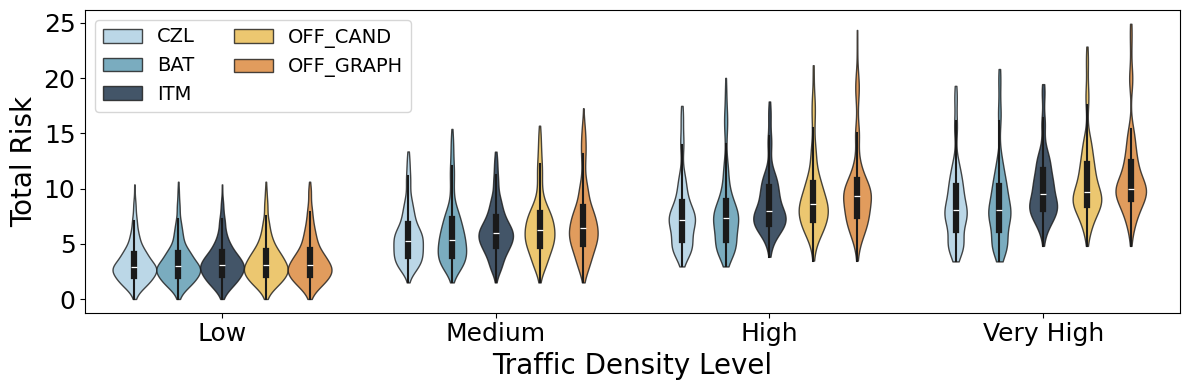

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


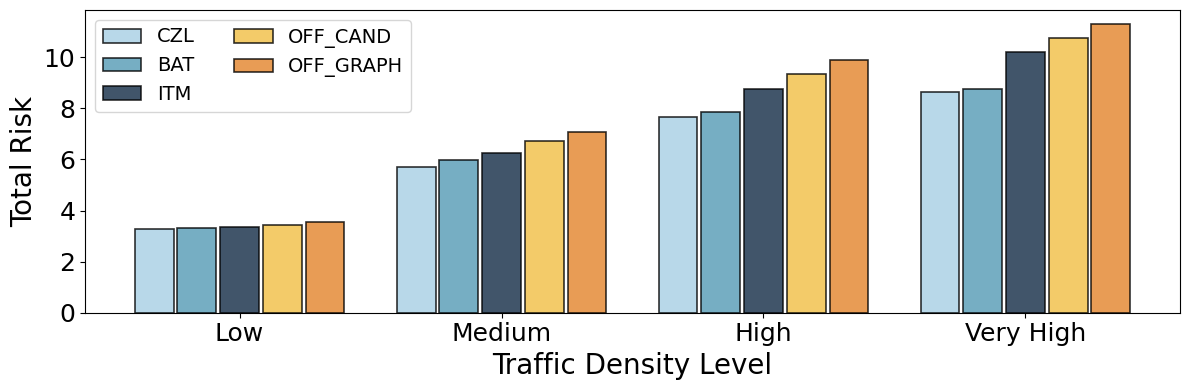

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


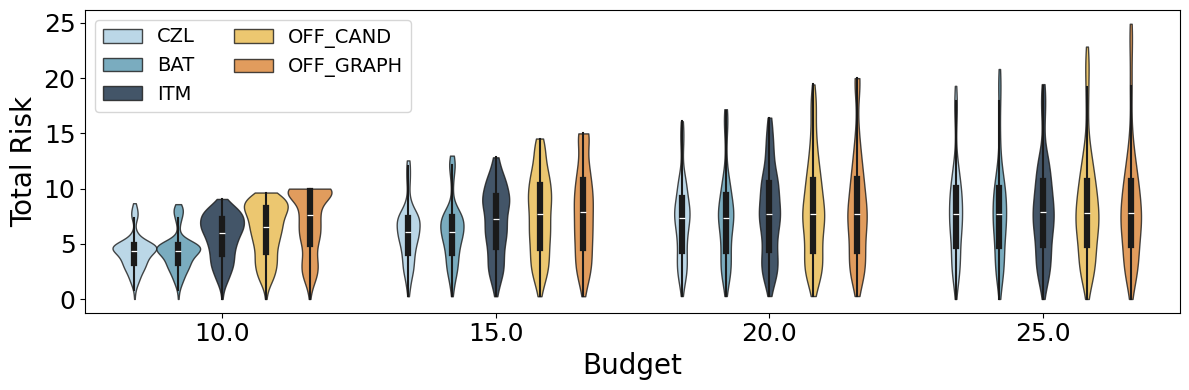

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


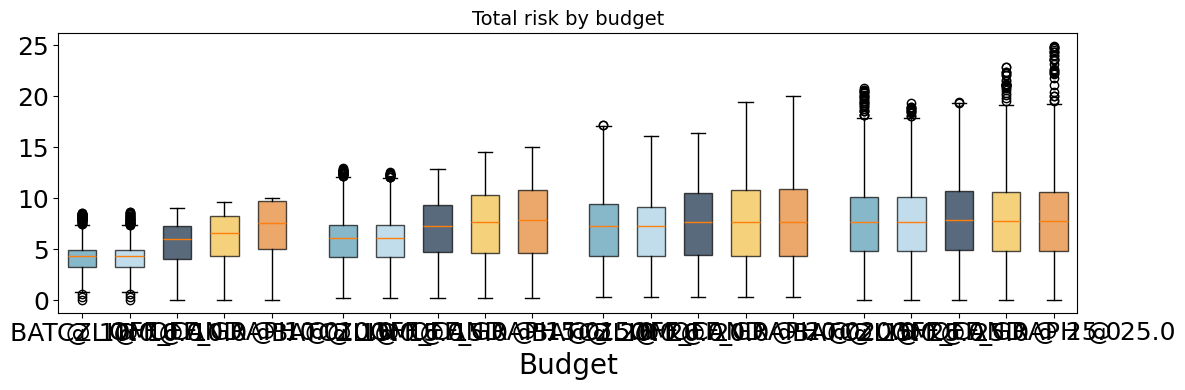

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


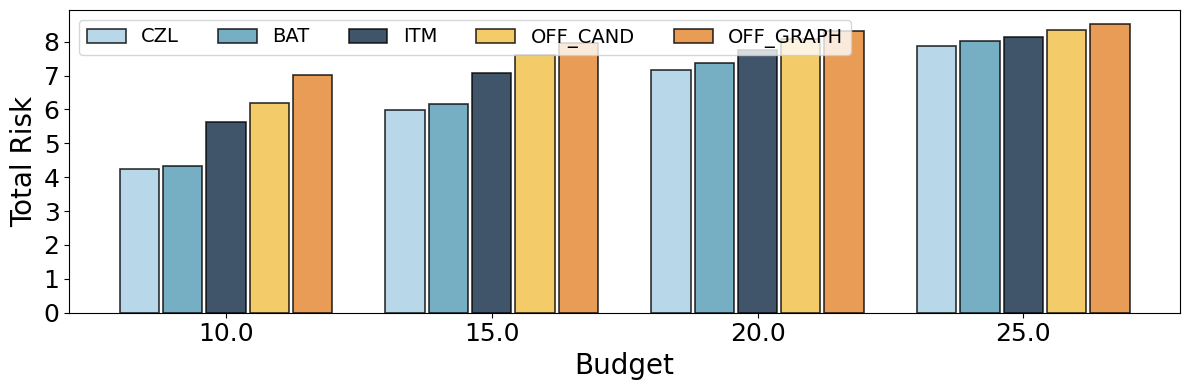

In [26]:

CURRENT_PLOT_SUBDIR = 'risk'
xlabel = 'Traffic Density Level'
# By risk label
violin_metric(risk_df, 'total_risk', 'risk_level_display', 'algorithm', 'Total Consumed Risk', xlabel=xlabel, save=True, legend_ncol=2)
# boxplot_metric(risk_df, 'total_risk', 'risk_level_display', 'algorithm', 'Total risk by traffic density', xlabel=xlabel, save=True)
bar_metric(risk_df, 'total_risk', 'risk_level_display', 'algorithm', 'Mean total risk by traffic density', xlabel=xlabel, save=True,legend_ncol=2)

# By budget
violin_metric(risk_df, 'total_risk', 'budget', 'algorithm', 'Total risk by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
boxplot_metric(risk_df, 'total_risk', 'budget', 'algorithm', 'Total risk by budget', xlabel='Budget', save=True)
bar_metric(risk_df, 'total_risk', 'budget', 'algorithm', 'Mean total risk by budget', xlabel='Budget', save=True, legend_ncol=5)

## Utility totals by traffic density and budget

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


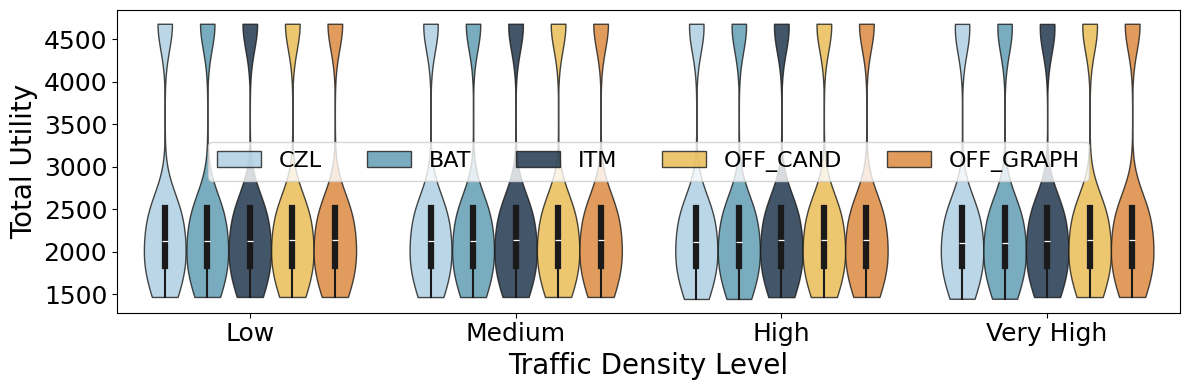

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


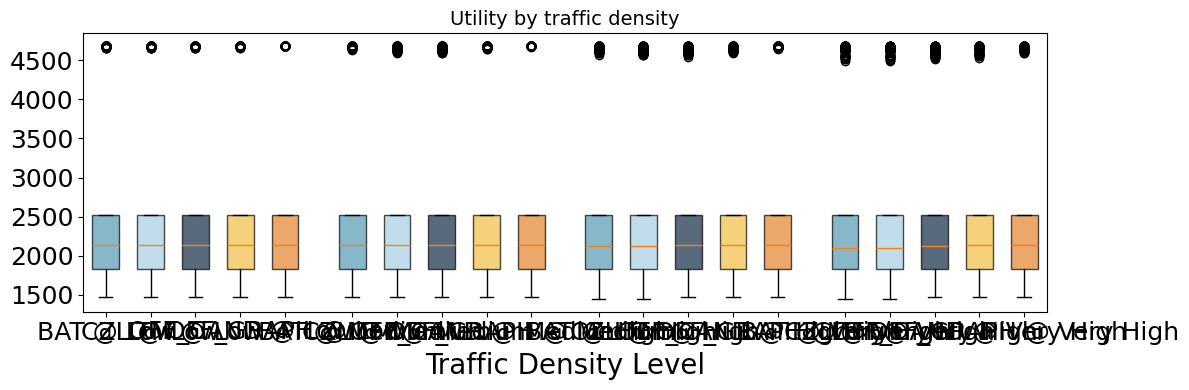

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/3792761668.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


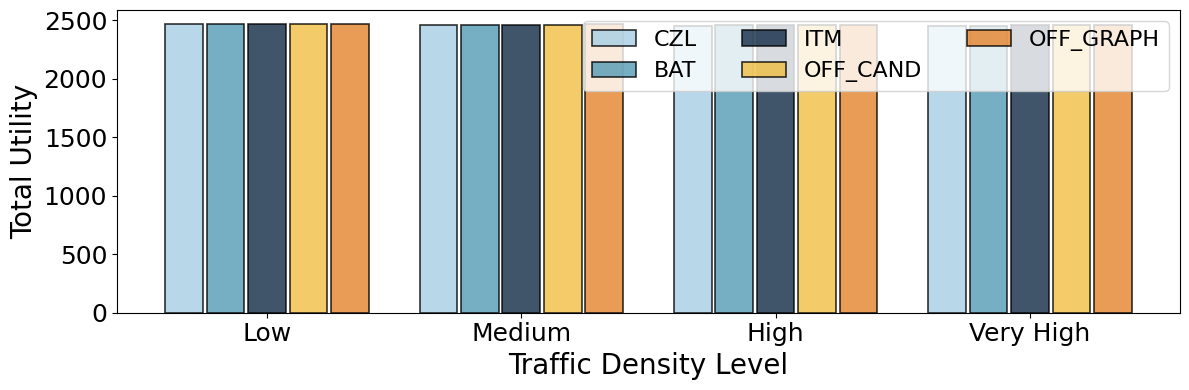

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


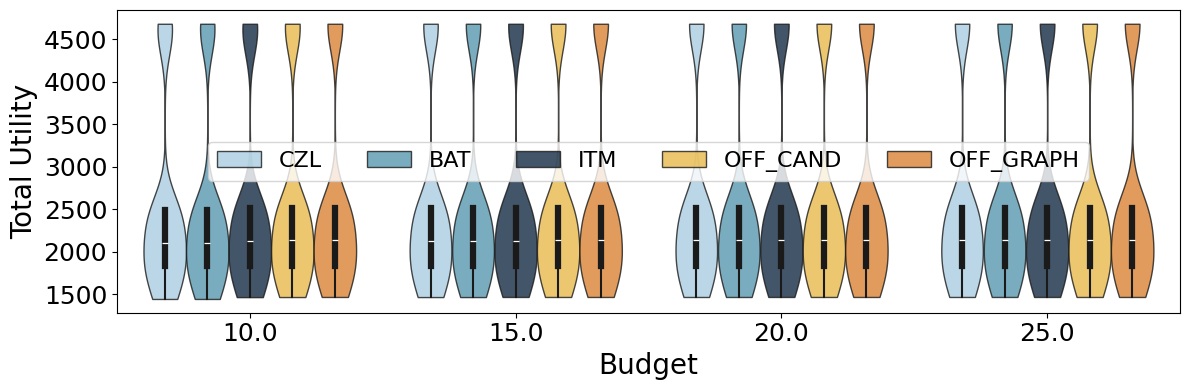

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


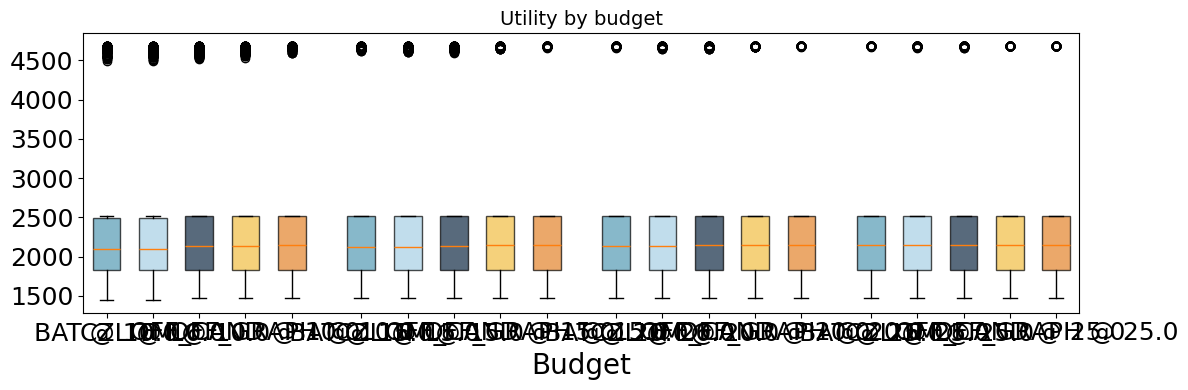

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


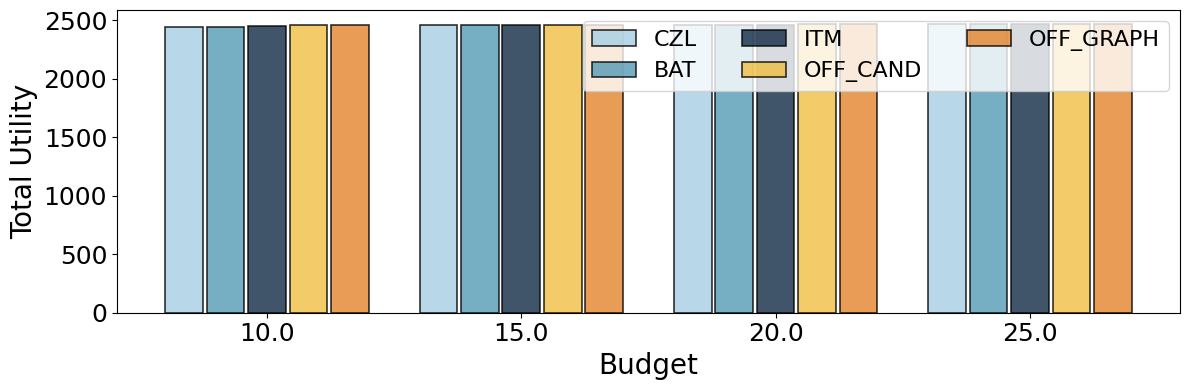

In [11]:

CURRENT_PLOT_SUBDIR = 'utility'
xlabel = 'Traffic Density Level'
# By traffic density (risk level)
violin_metric(utility_df, 'total_utility', 'risk_level_display', 'algorithm', 'Utility by traffic density (violin)', xlabel=xlabel, save=True)
boxplot_metric(utility_df, 'total_utility', 'risk_level_display', 'algorithm', 'Utility by traffic density', xlabel=xlabel, save=True)
bar_metric(utility_df, 'total_utility', 'risk_level_display', 'algorithm', 'Mean utility by traffic density', xlabel=xlabel, save=True)

# By budget
violin_metric(utility_df, 'total_utility', 'budget', 'algorithm', 'Utility by budget (violin)', xlabel='Budget', save=True)
boxplot_metric(utility_df, 'total_utility', 'budget', 'algorithm', 'Utility by budget', xlabel='Budget', save=True)
bar_metric(utility_df, 'total_utility', 'budget', 'algorithm', 'Mean utility by budget', xlabel='Budget', save=True)


### Utility totals without outliers (IQR filter per algorithm)

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


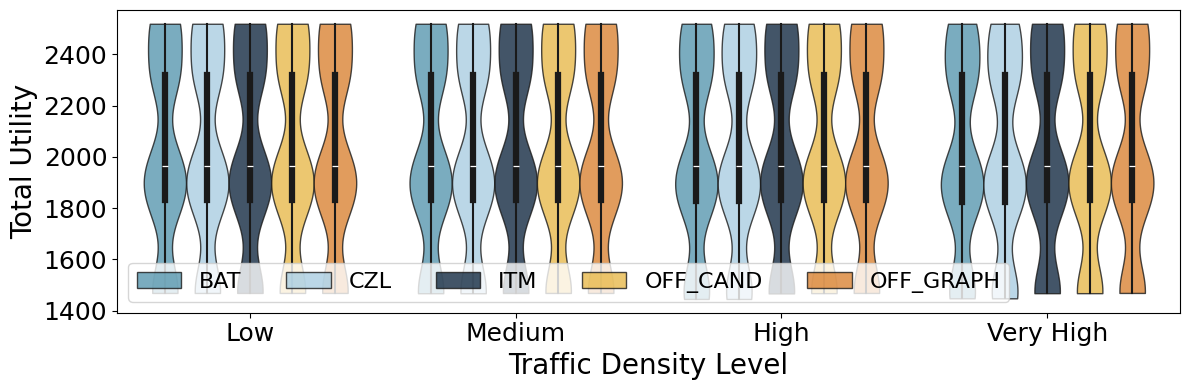

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


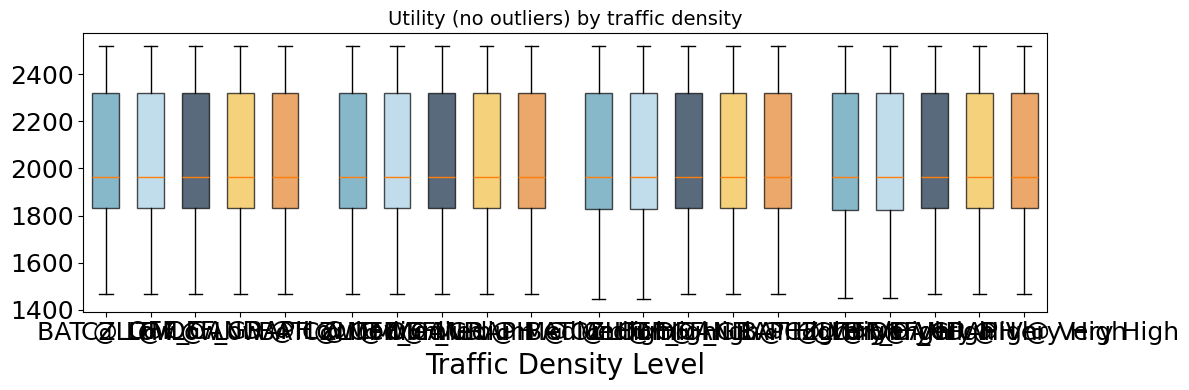

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/3792761668.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


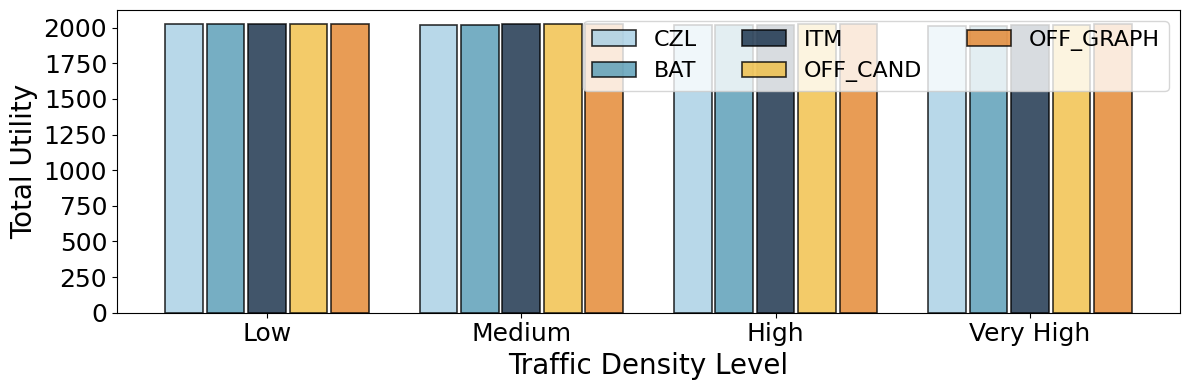

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


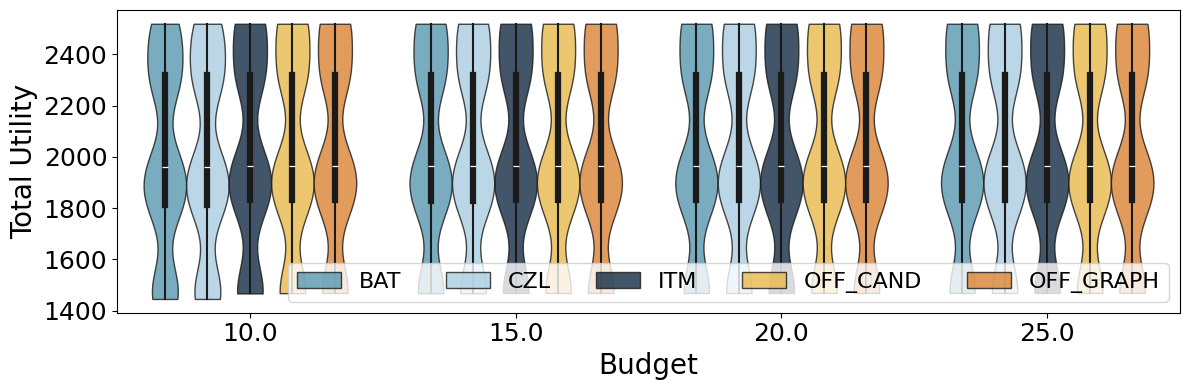

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


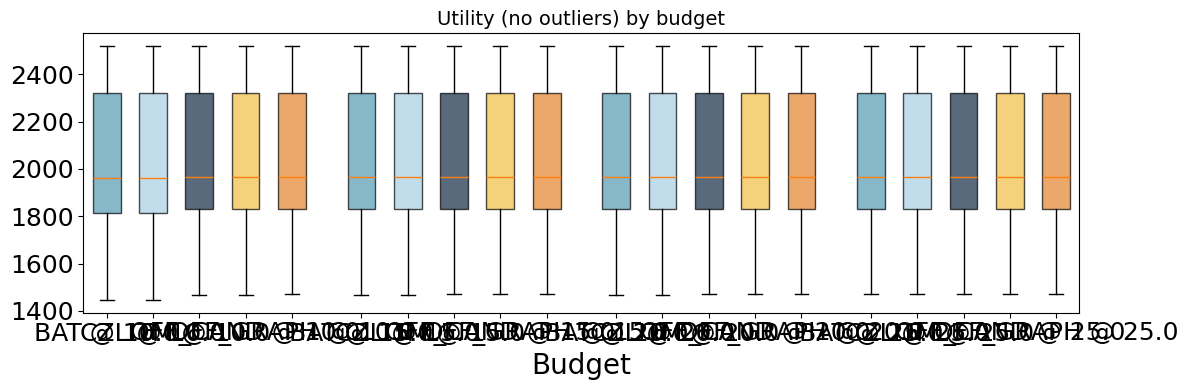

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


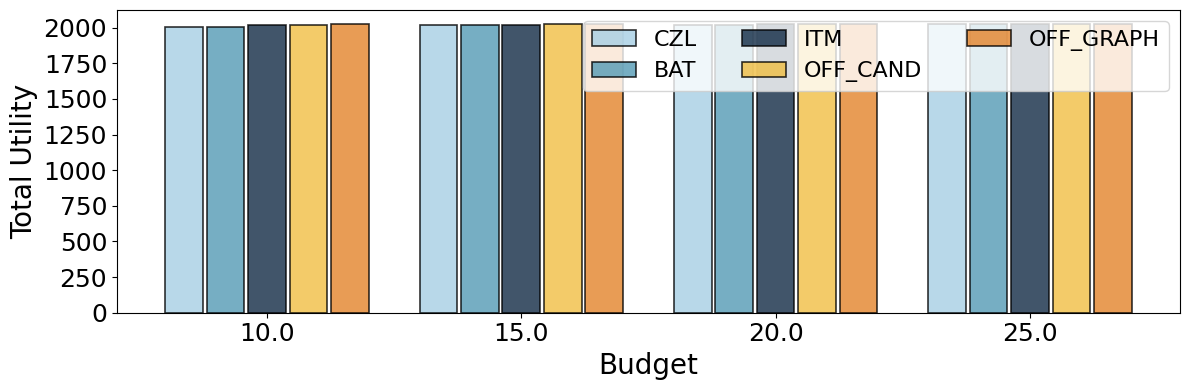

In [12]:

# Remove outliers per algorithm using IQR (1.5x)
utility_no_outliers = remove_outliers_iqr(utility_df, 'total_utility')

CURRENT_PLOT_SUBDIR = 'utility_no_outliers'
xlabel = 'Traffic Density Level'
# By traffic density (risk level)
violin_metric(utility_no_outliers, 'total_utility', 'risk_level_display', 'algorithm', 'Utility (no outliers) by traffic density (violin)', xlabel=xlabel, save=True)
boxplot_metric(utility_no_outliers, 'total_utility', 'risk_level_display', 'algorithm', 'Utility (no outliers) by traffic density', xlabel=xlabel, save=True)
bar_metric(utility_no_outliers, 'total_utility', 'risk_level_display', 'algorithm', 'Mean utility (no outliers) by traffic density', xlabel=xlabel, save=True)

# By budget
violin_metric(utility_no_outliers, 'total_utility', 'budget', 'algorithm', 'Utility (no outliers) by budget (violin)', xlabel='Budget', save=True)
boxplot_metric(utility_no_outliers, 'total_utility', 'budget', 'algorithm', 'Utility (no outliers) by budget', xlabel='Budget', save=True)
bar_metric(utility_no_outliers, 'total_utility', 'budget', 'algorithm', 'Mean utility (no outliers) by budget', xlabel='Budget', save=True)


### Utility deltas vs offline graph opt (to highlight small differences)

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


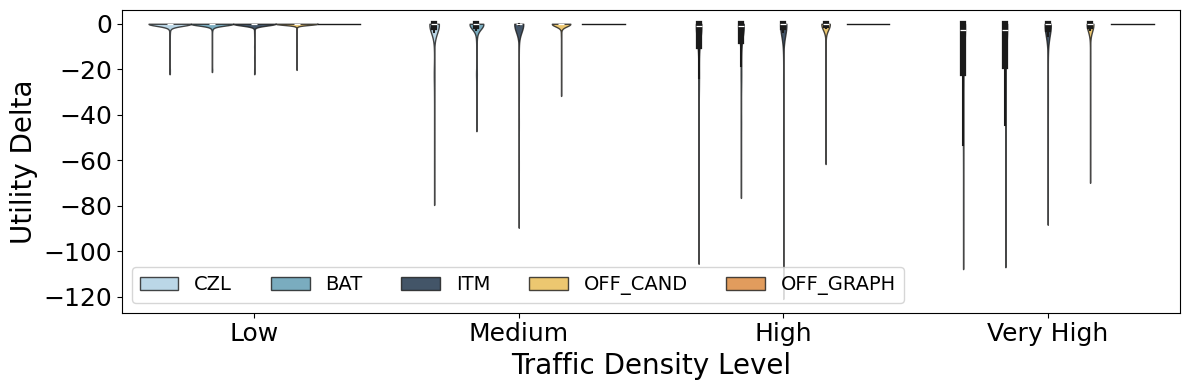

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


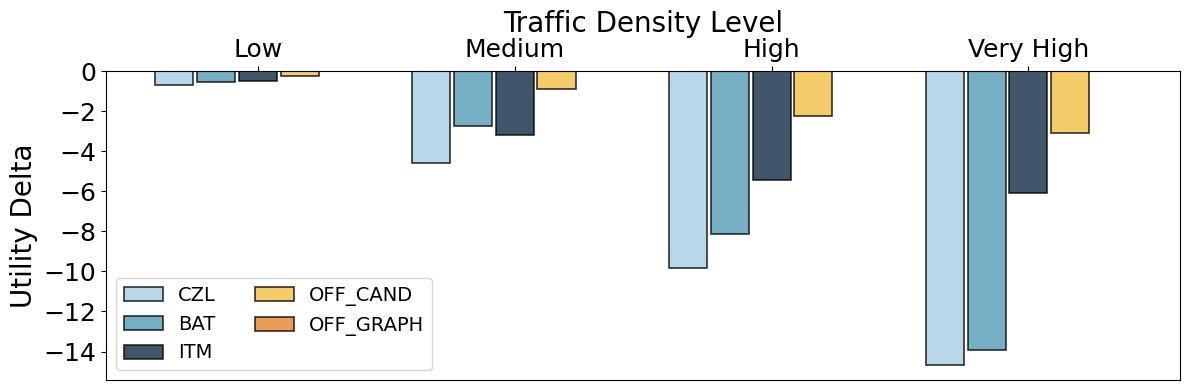

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


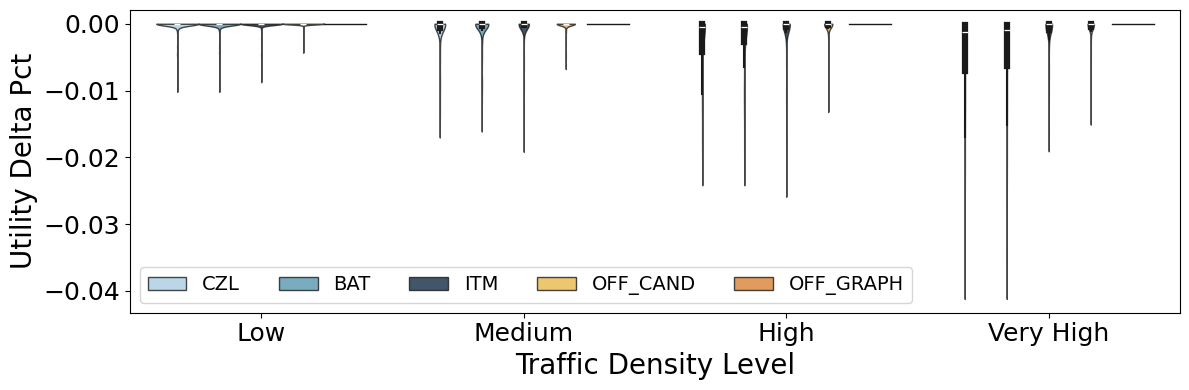

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


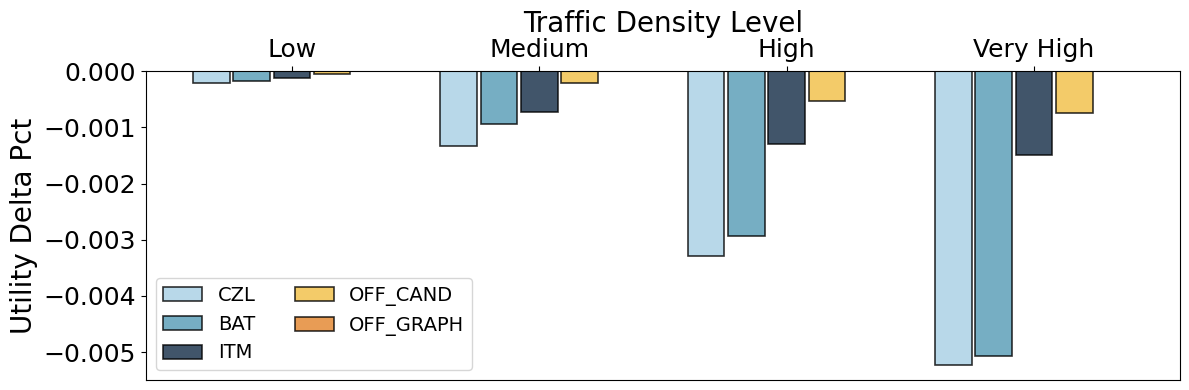

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


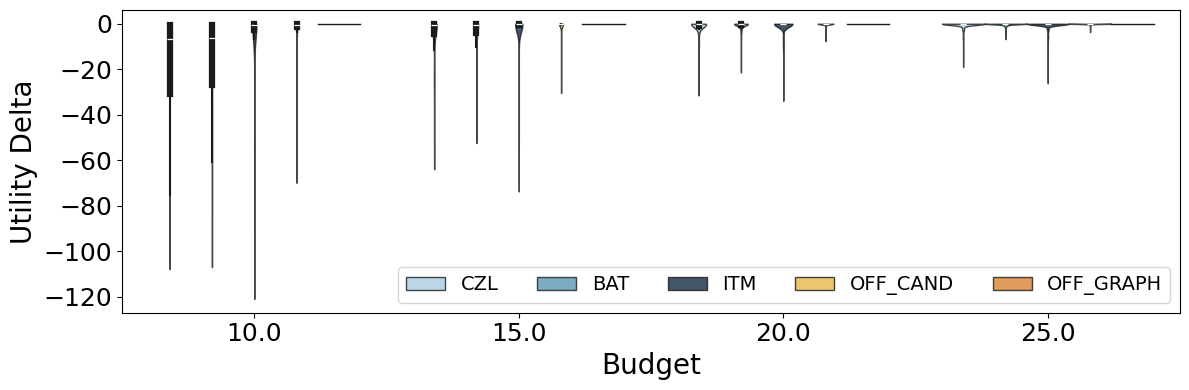

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


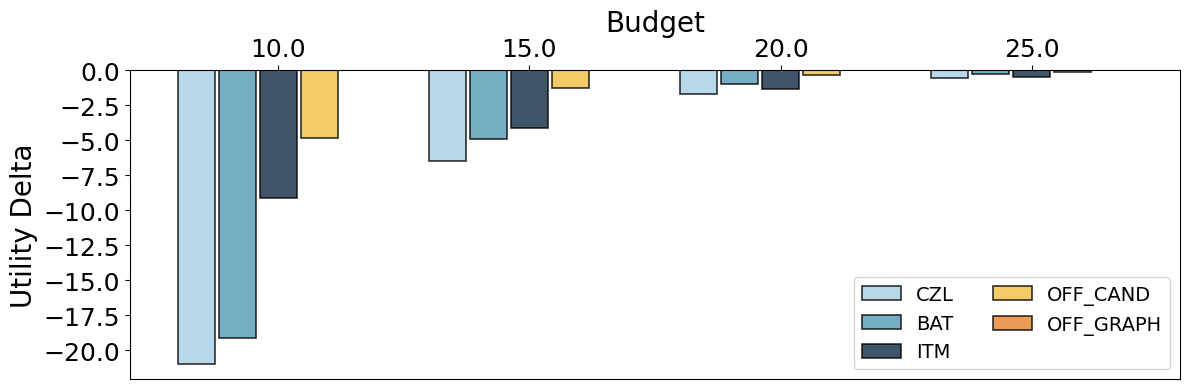

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


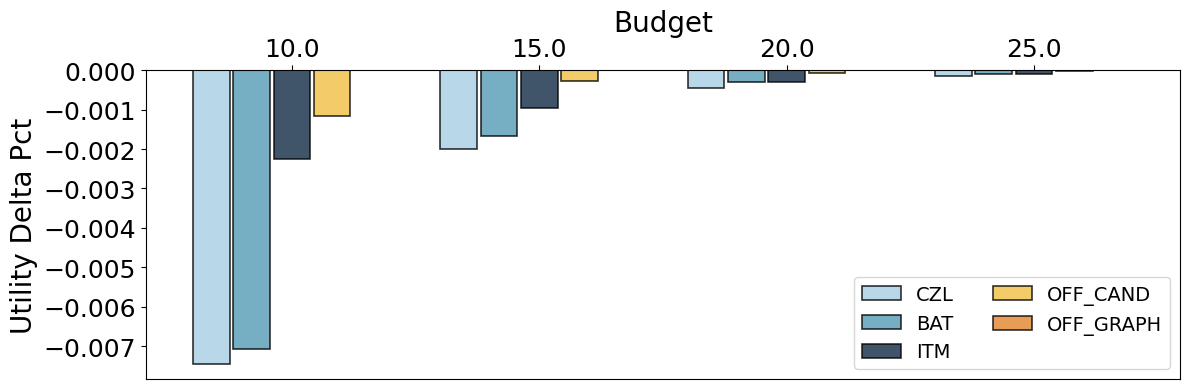

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


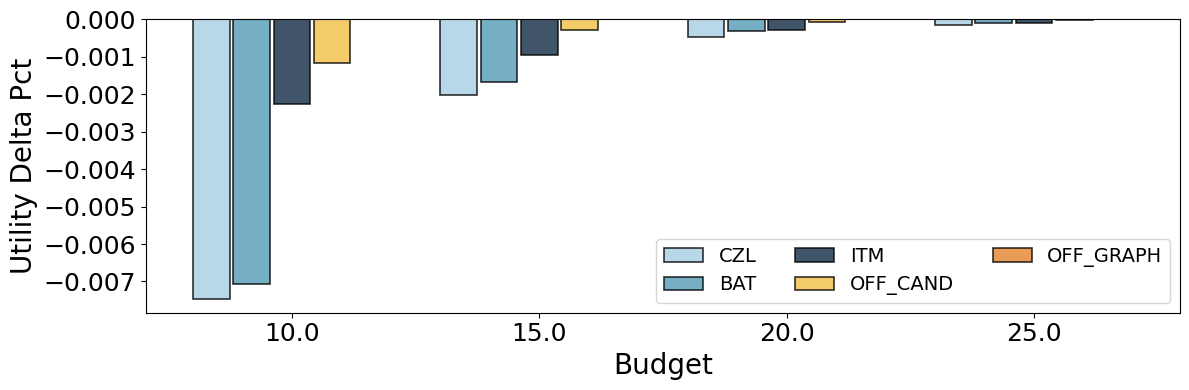

In [30]:

# Zero-centered deltas and percent deltas versus offline graph optimum
CURRENT_PLOT_SUBDIR = 'utility_delta'
xlabel = 'Traffic Density Level'

# Absolute delta by traffic density
violin_metric(utility_delta_df, 'utility_delta', 'risk_level_display', 'algorithm', 'Utility delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True)
# boxplot_metric(utility_delta_df, 'utility_delta', 'risk_level_display', 'algorithm', 'Utility delta vs offline graph by traffic density', xlabel=xlabel, save=True)
bar_metric_with_top_xlabel(utility_delta_df, 'utility_delta', 'risk_level_display', 'algorithm', 'Mean utility delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)

# Percent delta by traffic density
violin_metric(utility_delta_df, 'utility_delta_pct', 'risk_level_display', 'algorithm', 'Utility % delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True)
# boxplot_metric(utility_delta_df, 'utility_delta_pct', 'risk_level_display', 'algorithm', 'Utility % delta vs offline graph by traffic density', xlabel=xlabel, save=True)
bar_metric_with_top_xlabel(utility_delta_df, 'utility_delta_pct', 'risk_level_display', 'algorithm', 'Mean utility % delta vs offline graph by traffic density', xlabel=xlabel, save=True,legend_ncol=2)

# Absolute delta by budget
violin_metric(utility_delta_df, 'utility_delta', 'budget', 'algorithm', 'Utility delta vs offline graph by budget (violin)', xlabel='Budget', save=True)
# boxplot_metric(utility_delta_df, 'utility_delta', 'budget', 'algorithm', 'Utility delta vs offline graph by budget', xlabel='Budget', save=True)``
bar_metric_with_top_xlabel(utility_delta_df, 'utility_delta', 'budget', 'algorithm', 'Mean utility delta vs offline graph by budget', xlabel='Budget', save=True,legend_ncol=2,position='lower right')

# Percent delta by budget
bar_metric_with_top_xlabel(utility_delta_df, 'utility_delta_pct', 'budget', 'algorithm', 'Utility % delta vs offline graph by budget (violin)', xlabel='Budget', save=True,legend_ncol=2, position='lower right')
# boxplot_metric(utility_delta_df, 'utility_delta_pct', 'budget', 'algorithm', 'Utility % delta vs offline graph by budget', xlabel='Budget', save=True)
bar_metric(utility_delta_df, 'utility_delta_pct', 'budget', 'algorithm', 'Mean utility % delta vs offline graph by budget', xlabel='Budget', save=True)


## Total cost by traffic density and budget

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


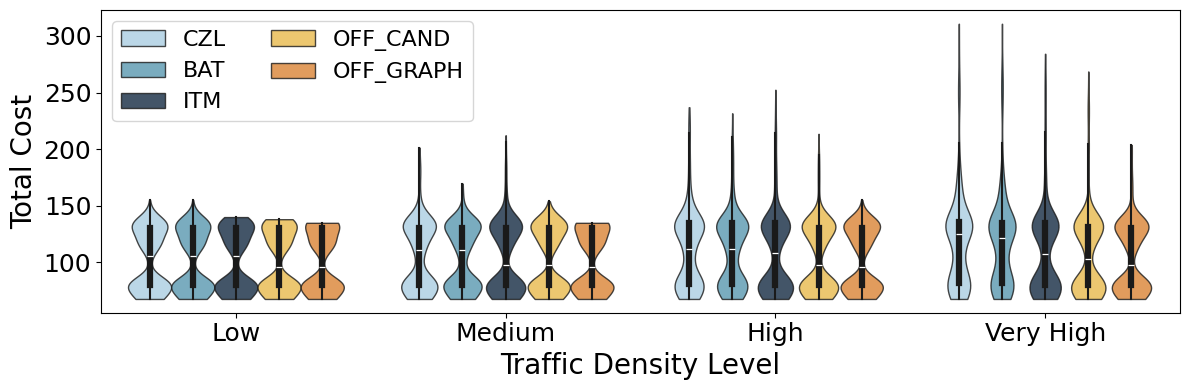

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


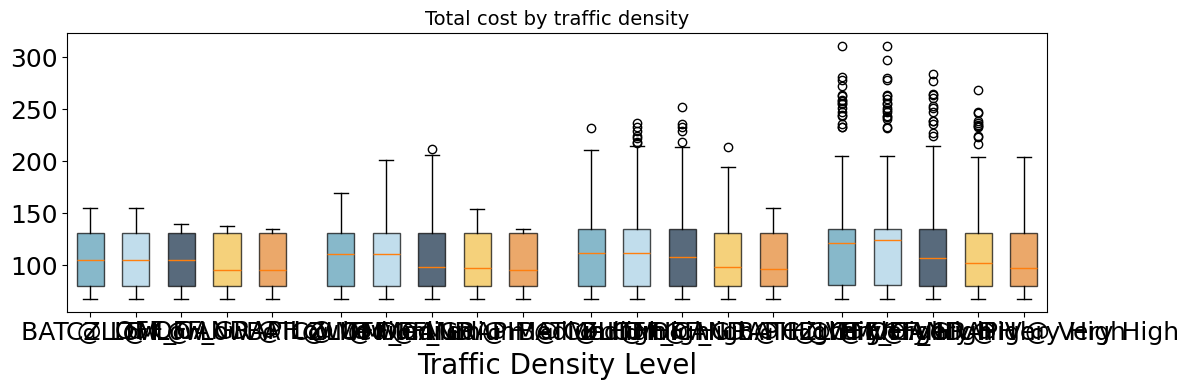

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/3792761668.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


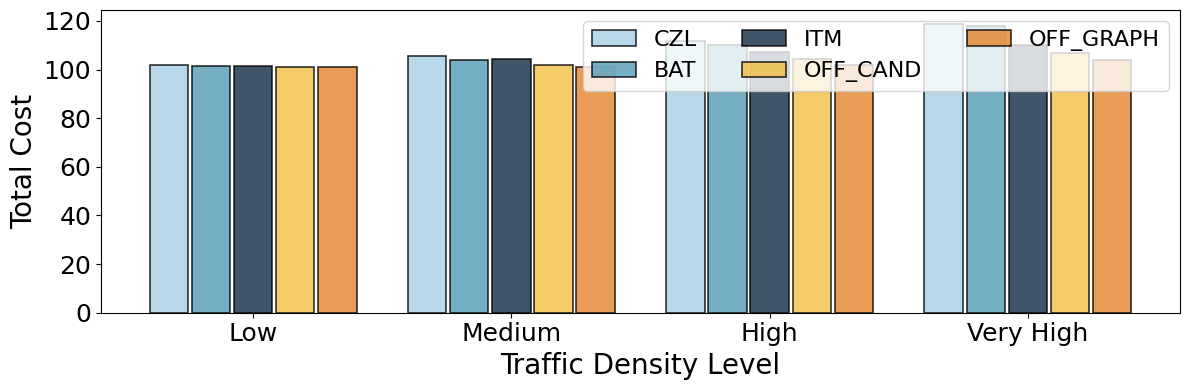

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


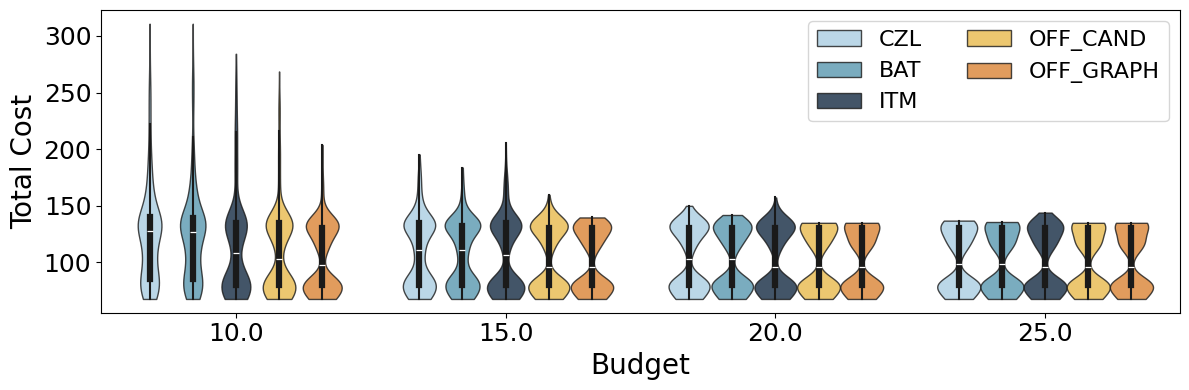

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


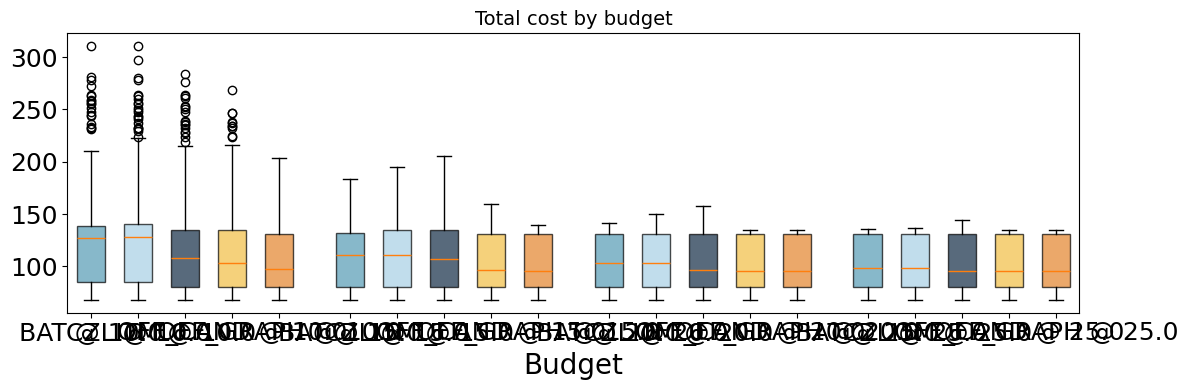

/tmp/ipykernel_12121/3792761668.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


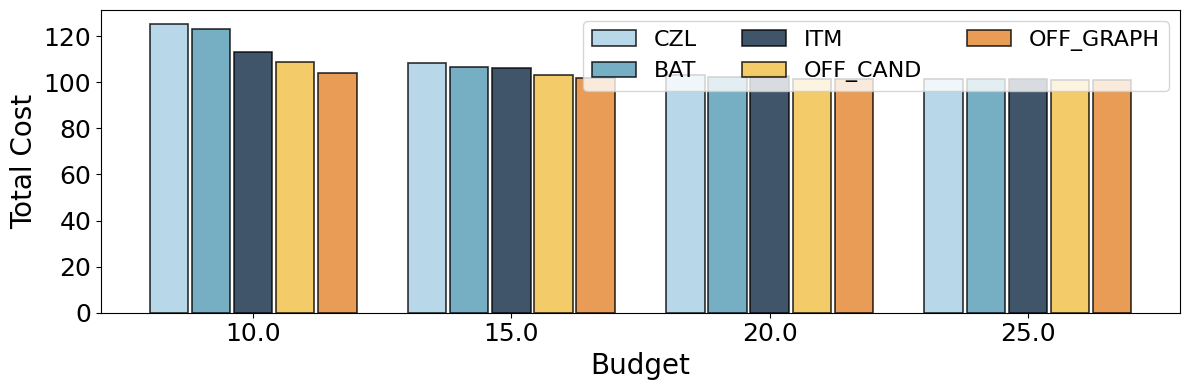

In [14]:

CURRENT_PLOT_SUBDIR = 'cost'
xlabel = 'Traffic Density Level'
violin_metric(cost_df, 'total_cost', 'risk_level_display', 'algorithm', 'Total cost by traffic density (violin)', xlabel=xlabel, save=True, legend_ncol=2)
boxplot_metric(cost_df, 'total_cost', 'risk_level_display', 'algorithm', 'Total cost by traffic density', xlabel=xlabel, save=True)
bar_metric(cost_df, 'total_cost', 'risk_level_display', 'algorithm', 'Mean total cost by traffic density', xlabel=xlabel, save=True)

violin_metric(cost_df, 'total_cost', 'budget', 'algorithm', 'Total cost by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
boxplot_metric(cost_df, 'total_cost', 'budget', 'algorithm', 'Total cost by budget', xlabel='Budget', save=True)
bar_metric(cost_df, 'total_cost', 'budget', 'algorithm', 'Mean total cost by budget', xlabel='Budget', save=True)


### Total cost without outliers (IQR filter per algorithm)

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


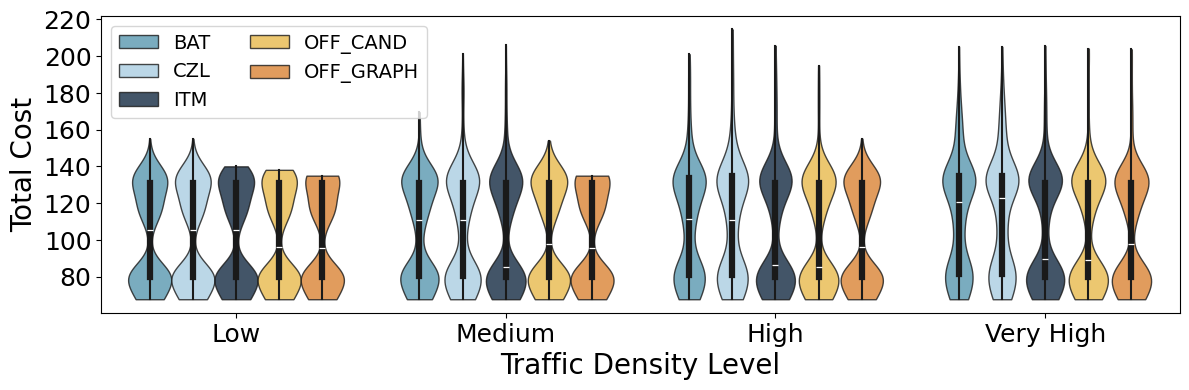

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


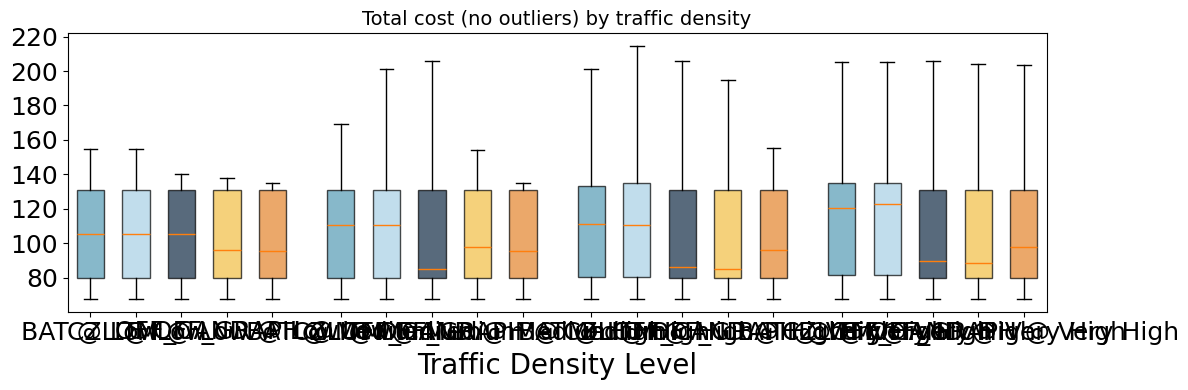

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


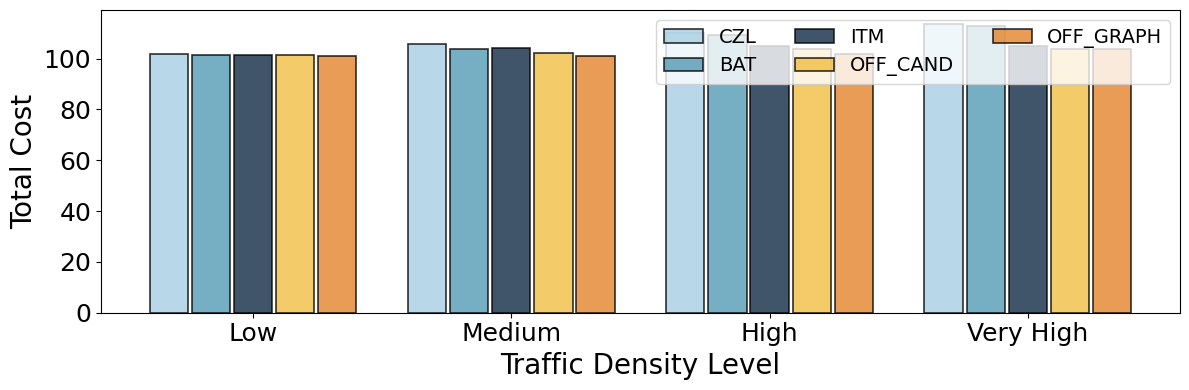

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


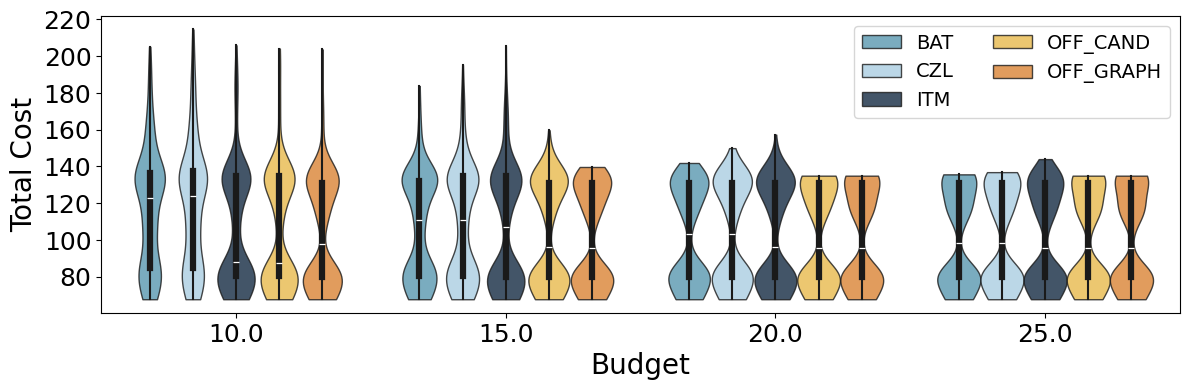

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


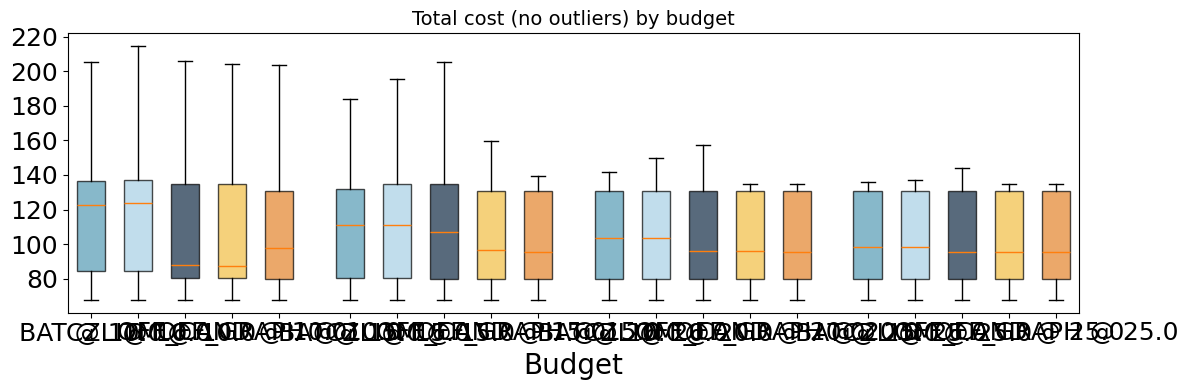

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


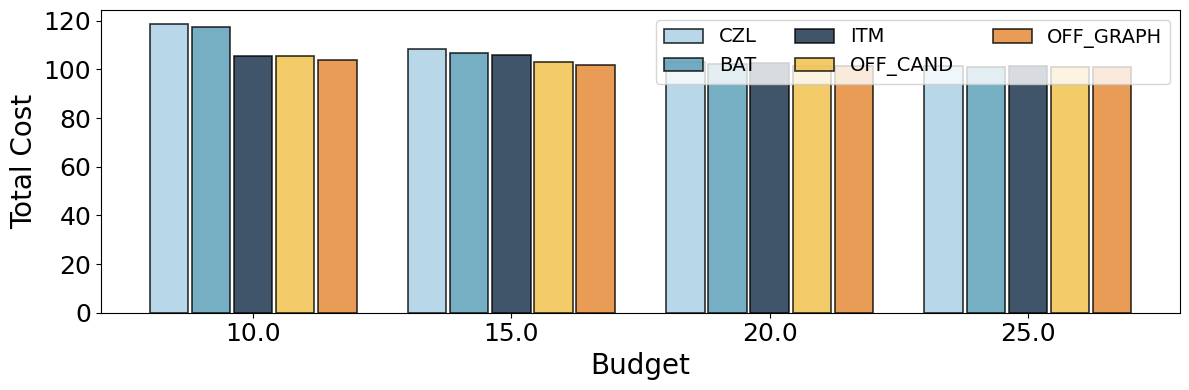

In [31]:

# Remove outliers per algorithm using IQR (1.5x)
cost_no_outliers = remove_outliers_iqr(cost_df, 'total_cost')

CURRENT_PLOT_SUBDIR = 'cost_no_outliers'
xlabel = 'Traffic Density Level'
violin_metric(cost_no_outliers, 'total_cost', 'risk_level_display', 'algorithm', 'Total cost (no outliers) by traffic density (violin)', xlabel=xlabel, save=True, legend_ncol=2)
boxplot_metric(cost_no_outliers, 'total_cost', 'risk_level_display', 'algorithm', 'Total cost (no outliers) by traffic density', xlabel=xlabel, save=True)
bar_metric(cost_no_outliers, 'total_cost', 'risk_level_display', 'algorithm', 'Mean total cost (no outliers) by traffic density', xlabel=xlabel, save=True)

violin_metric(cost_no_outliers, 'total_cost', 'budget', 'algorithm', 'Total cost (no outliers) by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
boxplot_metric(cost_no_outliers, 'total_cost', 'budget', 'algorithm', 'Total cost (no outliers) by budget', xlabel='Budget', save=True)
bar_metric(cost_no_outliers, 'total_cost', 'budget', 'algorithm', 'Mean total cost (no outliers) by budget', xlabel='Budget', save=True)


### Total cost deltas vs offline graph opt

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


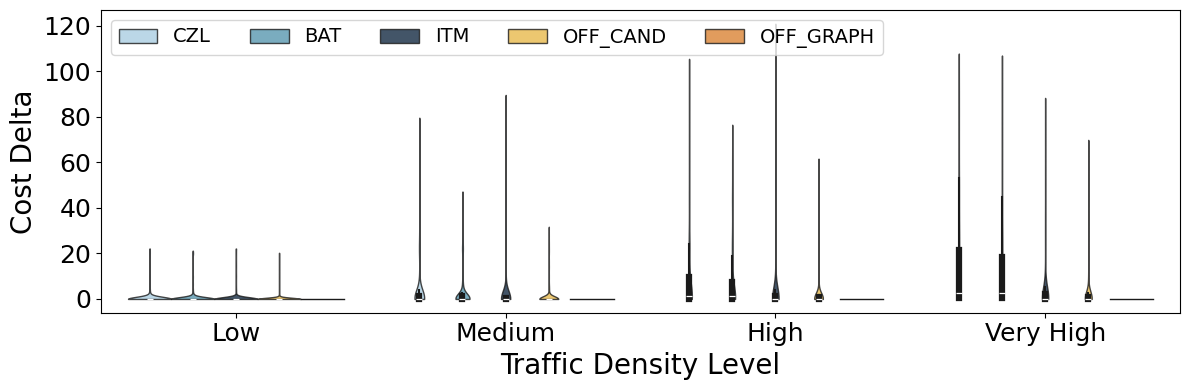

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


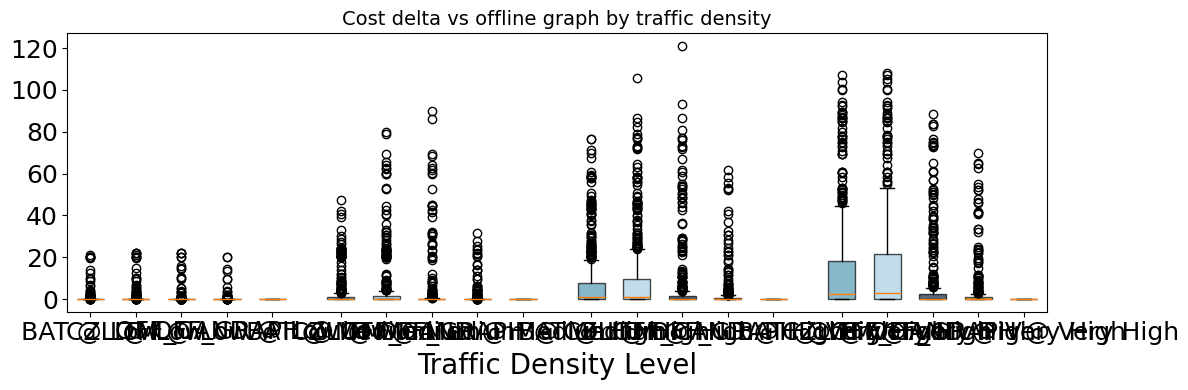

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


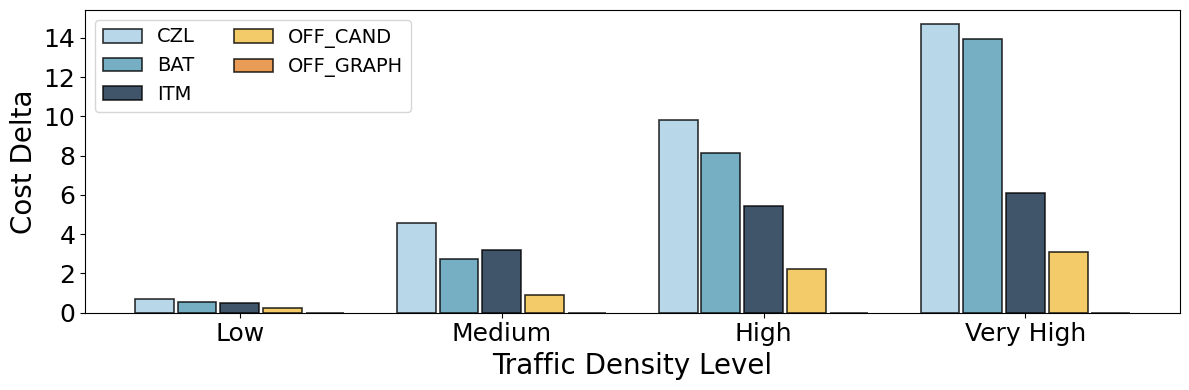

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


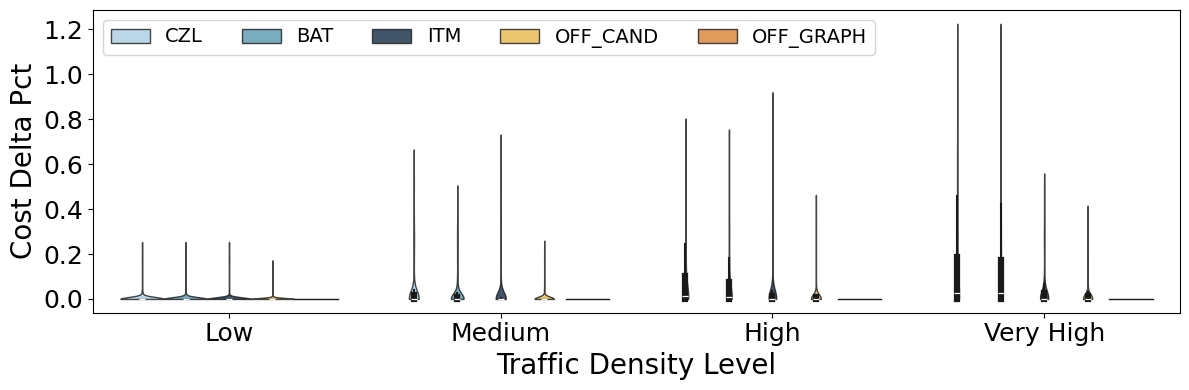

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


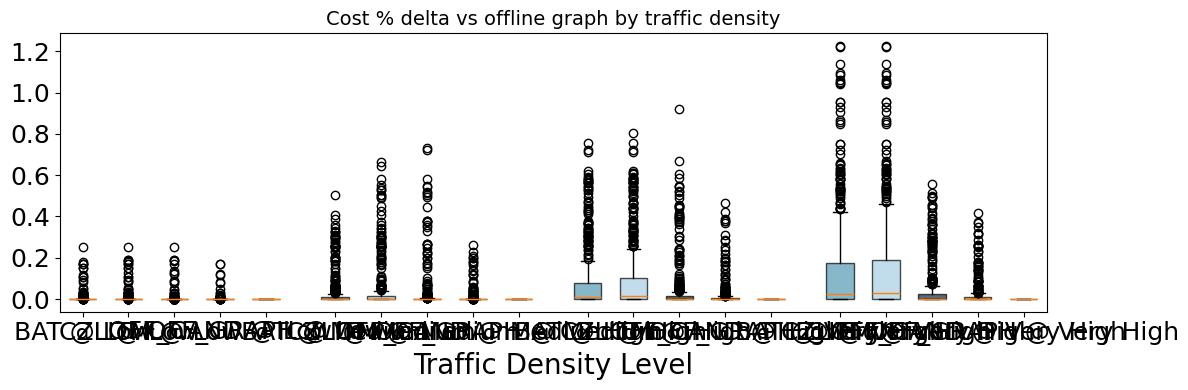

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


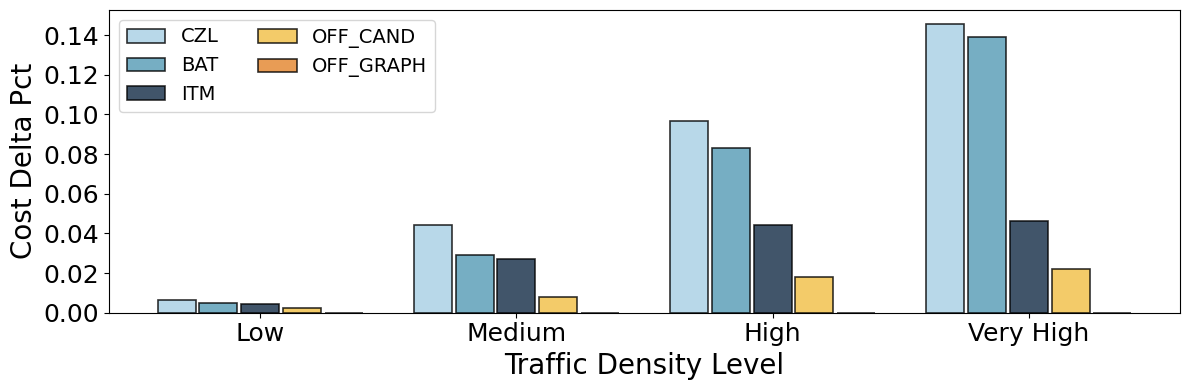

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


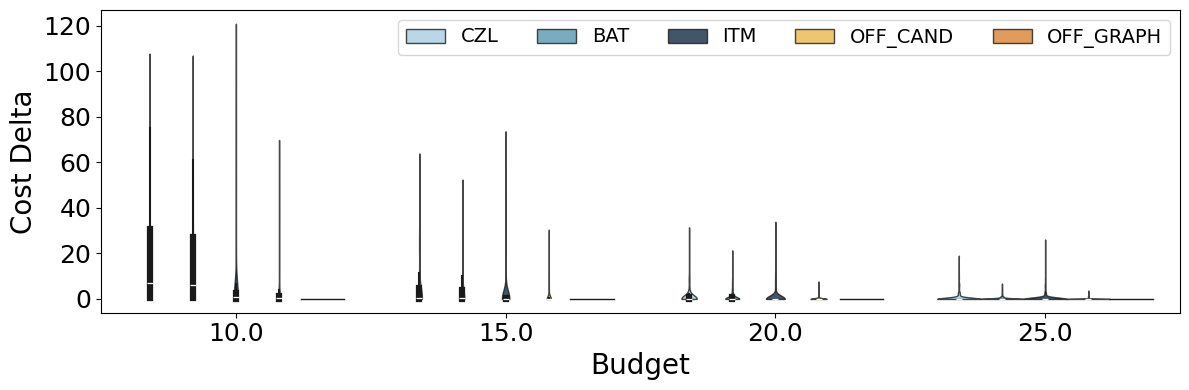

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


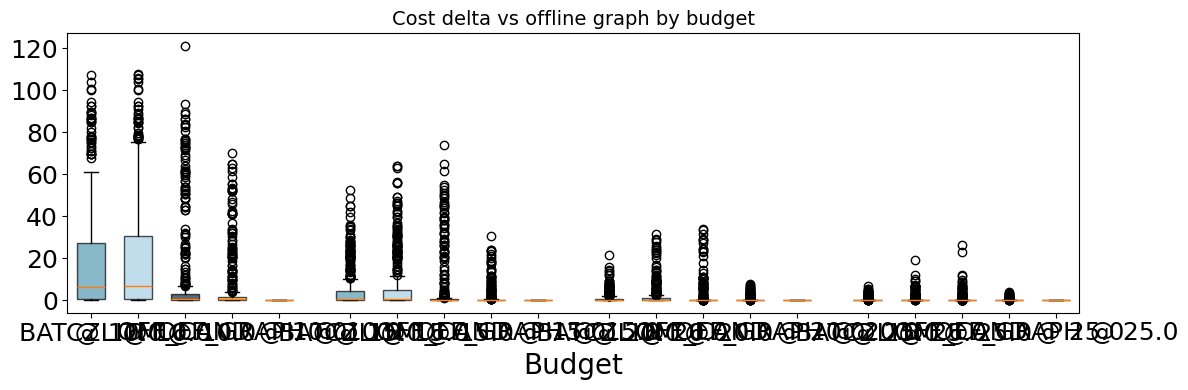

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


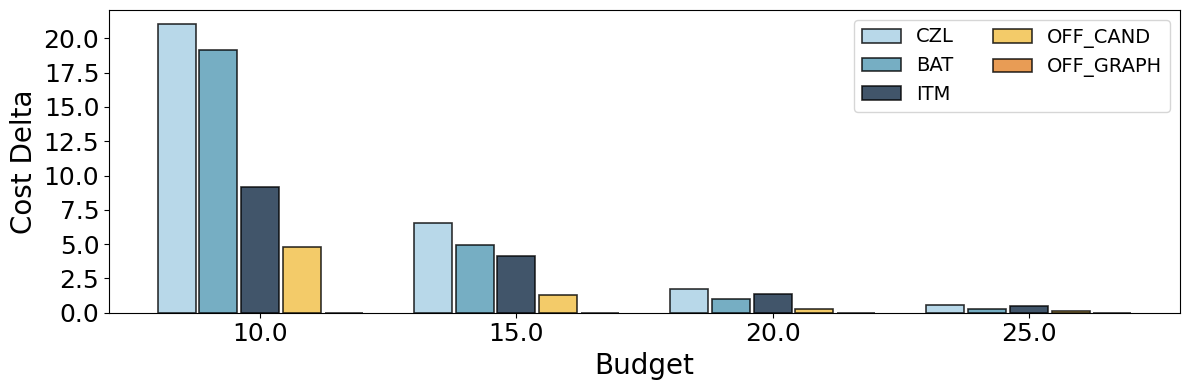

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


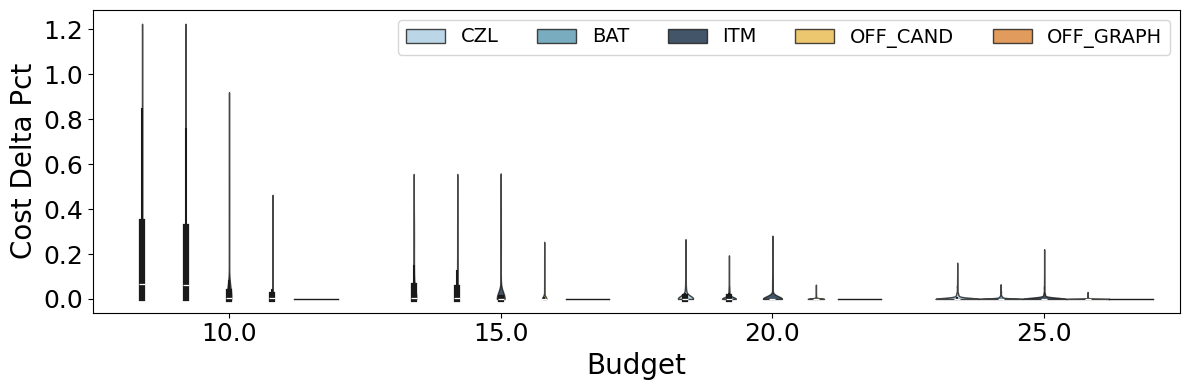

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


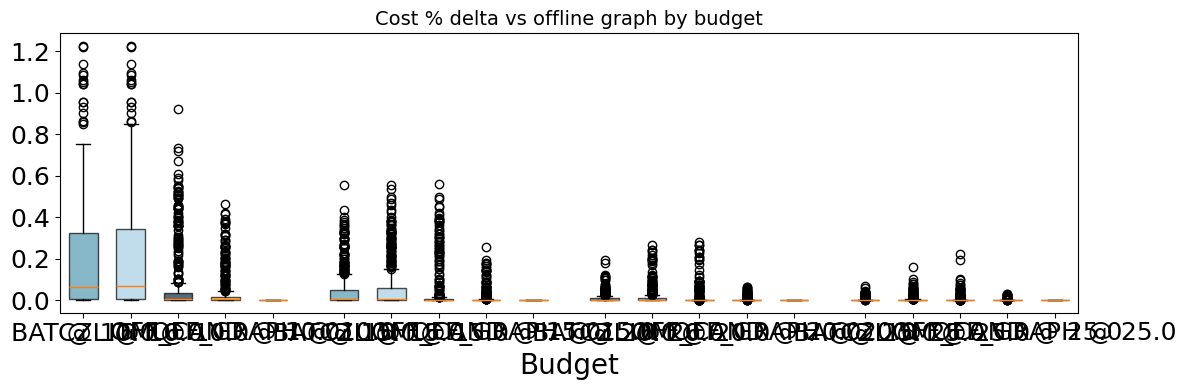

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


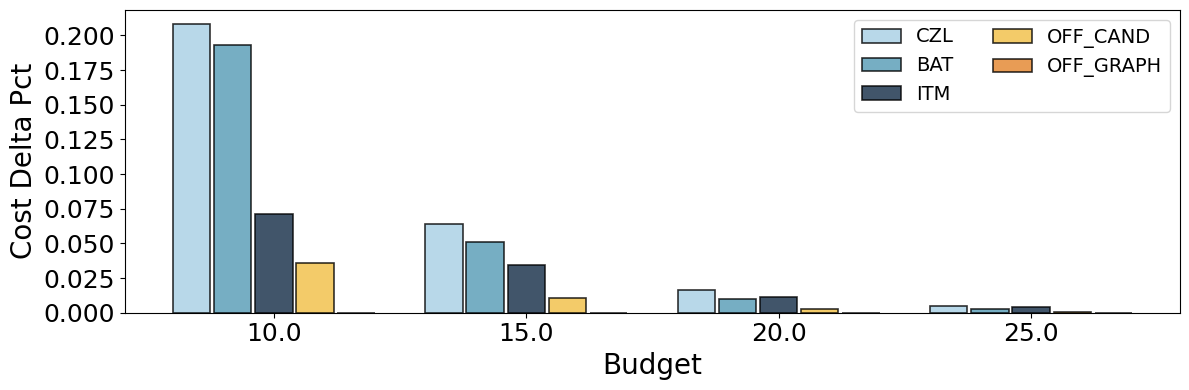

In [33]:

CURRENT_PLOT_SUBDIR = 'cost_delta'
xlabel = 'Traffic Density Level'
violin_metric(cost_delta_df, 'cost_delta', 'risk_level_display', 'algorithm', 'Cost delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True)
boxplot_metric(cost_delta_df, 'cost_delta', 'risk_level_display', 'algorithm', 'Cost delta vs offline graph by traffic density', xlabel=xlabel, save=True)
bar_metric(cost_delta_df, 'cost_delta', 'risk_level_display', 'algorithm', 'Mean cost delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)

violin_metric(cost_delta_df, 'cost_delta_pct', 'risk_level_display', 'algorithm', 'Cost % delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True)
boxplot_metric(cost_delta_df, 'cost_delta_pct', 'risk_level_display', 'algorithm', 'Cost % delta vs offline graph by traffic density', xlabel=xlabel, save=True)
bar_metric(cost_delta_df, 'cost_delta_pct', 'risk_level_display', 'algorithm', 'Mean cost % delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)

violin_metric(cost_delta_df, 'cost_delta', 'budget', 'algorithm', 'Cost delta vs offline graph by budget (violin)', xlabel='Budget', save=True)
boxplot_metric(cost_delta_df, 'cost_delta', 'budget', 'algorithm', 'Cost delta vs offline graph by budget', xlabel='Budget', save=True)
bar_metric(cost_delta_df, 'cost_delta', 'budget', 'algorithm', 'Mean cost delta vs offline graph by budget', xlabel='Budget', save=True, legend_ncol=2)

violin_metric(cost_delta_df, 'cost_delta_pct', 'budget', 'algorithm', 'Cost % delta vs offline graph by budget (violin)', xlabel='Budget', save=True)
boxplot_metric(cost_delta_df, 'cost_delta_pct', 'budget', 'algorithm', 'Cost % delta vs offline graph by budget', xlabel='Budget', save=True)
bar_metric(cost_delta_df, 'cost_delta_pct', 'budget', 'algorithm', 'Mean cost % delta vs offline graph by budget', xlabel='Budget', save=True, legend_ncol=2)


## Travel-time cost by traffic density and budget

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


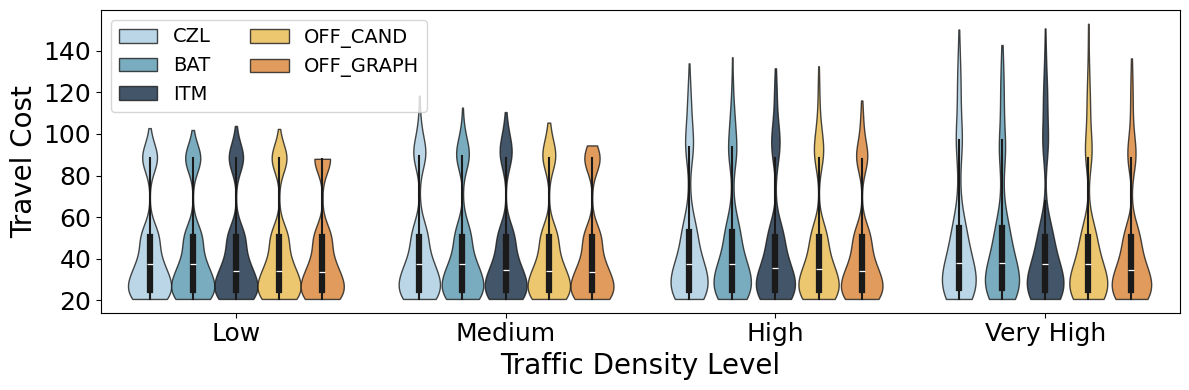

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


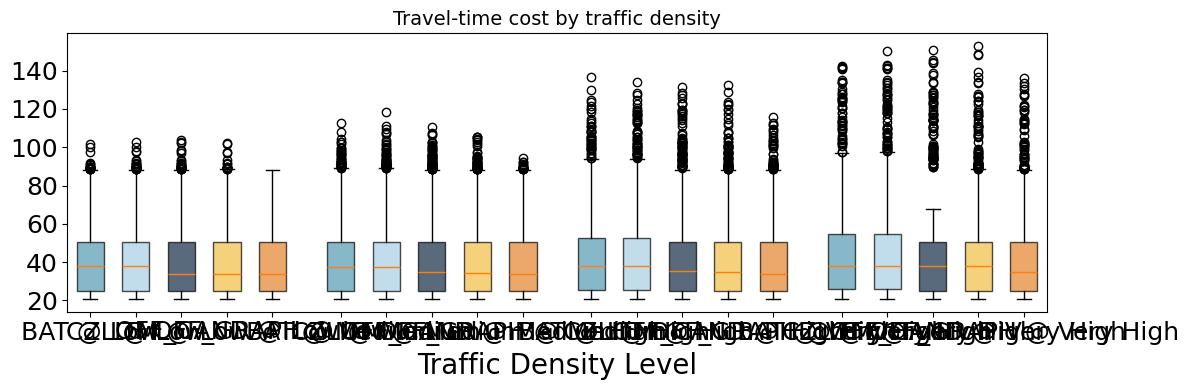

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


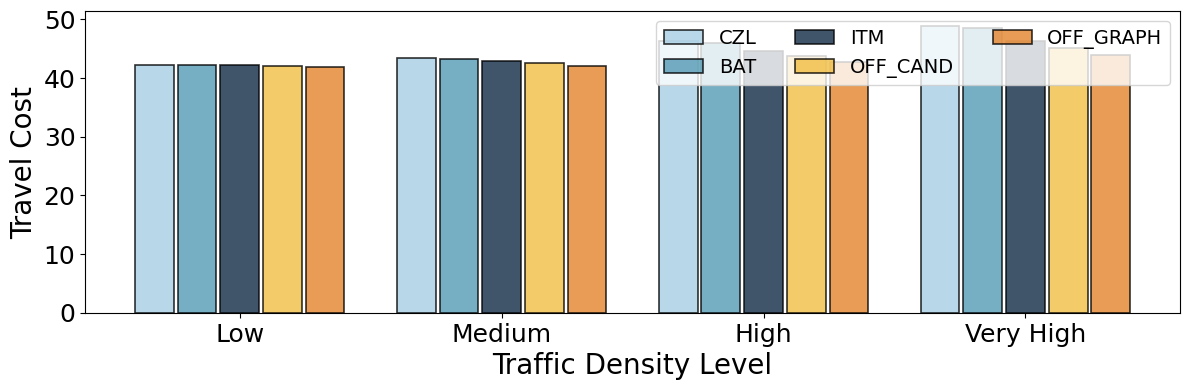

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


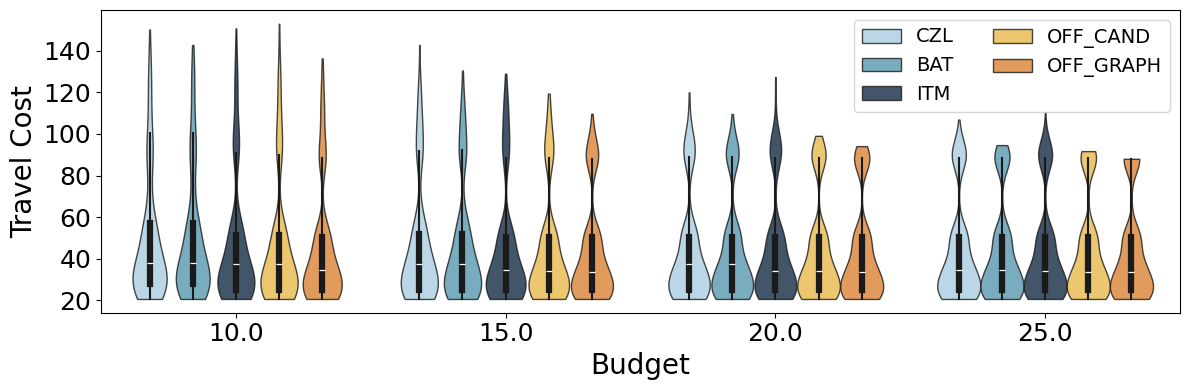

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


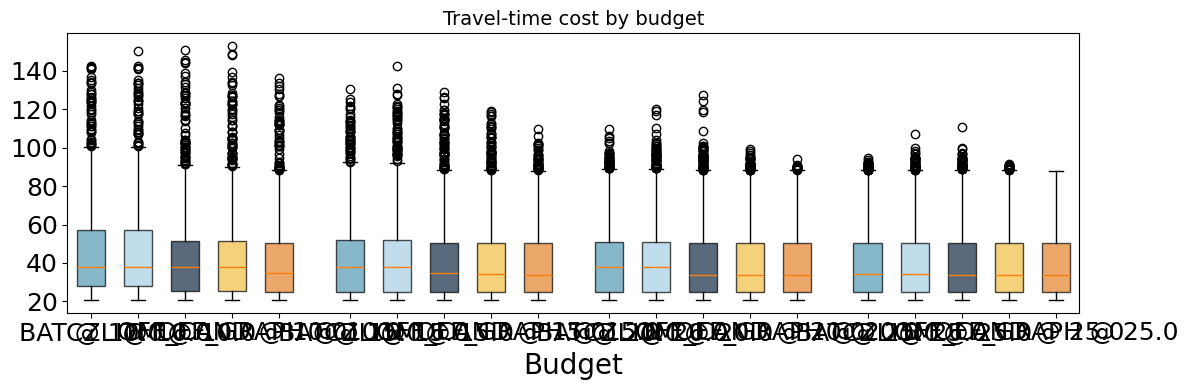

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


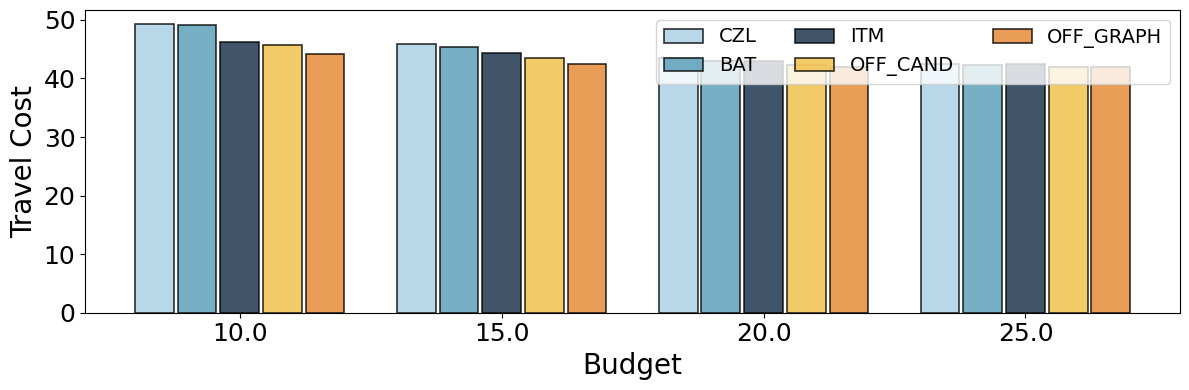

In [36]:

CURRENT_PLOT_SUBDIR = 'travel'
xlabel = 'Traffic Density Level'
violin_metric(travel_df, 'travel_cost', 'risk_level_display', 'algorithm', 'Travel-time cost by traffic density (violin)', xlabel=xlabel, save=True, legend_ncol=2)
boxplot_metric(travel_df, 'travel_cost', 'risk_level_display', 'algorithm', 'Travel-time cost by traffic density', xlabel=xlabel, save=True)
bar_metric(travel_df, 'travel_cost', 'risk_level_display', 'algorithm', 'Mean travel-time cost by traffic density', xlabel=xlabel, save=True)

violin_metric(travel_df, 'travel_cost', 'budget', 'algorithm', 'Travel-time cost by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
boxplot_metric(travel_df, 'travel_cost', 'budget', 'algorithm', 'Travel-time cost by budget', xlabel='Budget', save=True)
bar_metric(travel_df, 'travel_cost', 'budget', 'algorithm', 'Mean travel-time cost by budget', xlabel='Budget', save=True)


### Travel-time cost without outliers (IQR filter per algorithm)

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


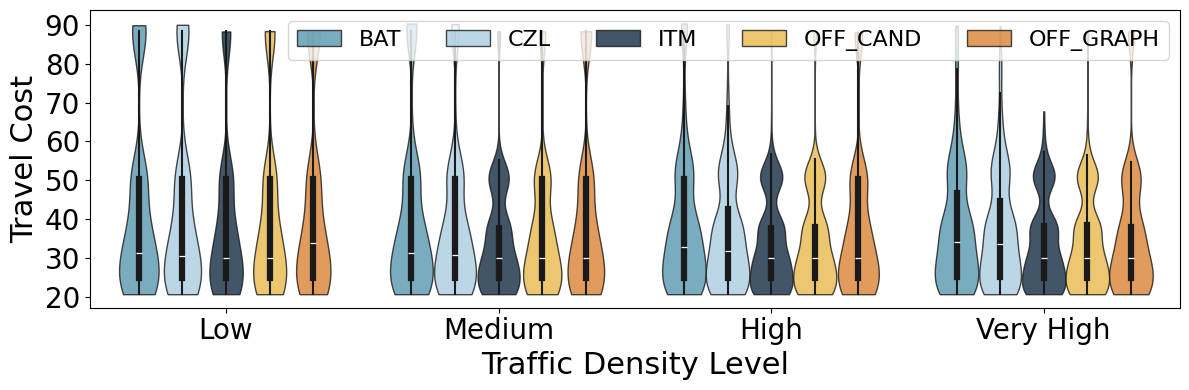

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


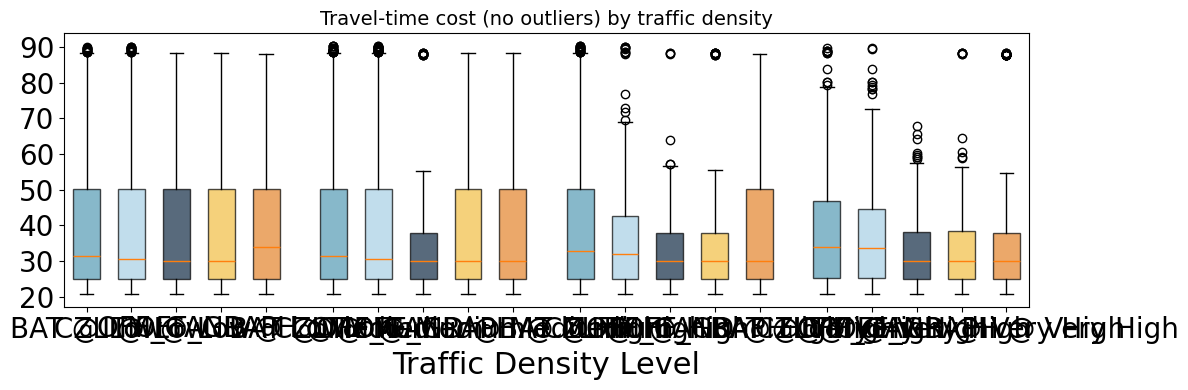

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_31183/1173993868.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


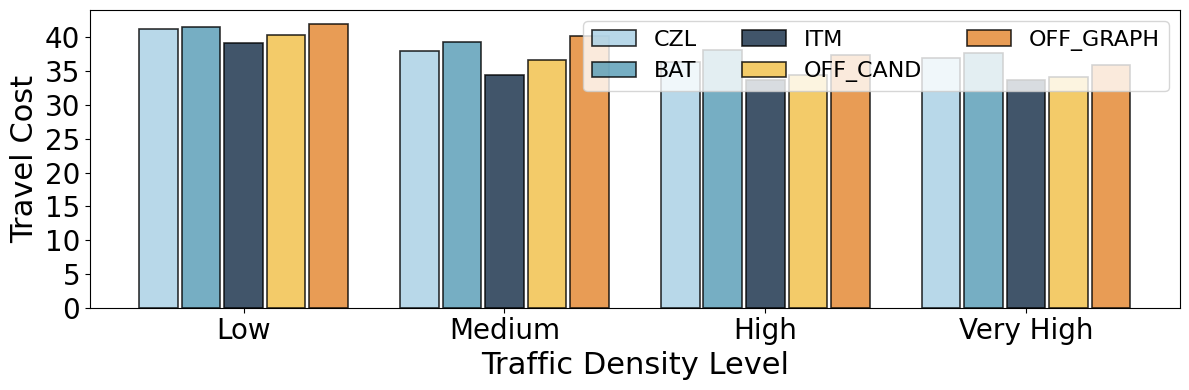

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


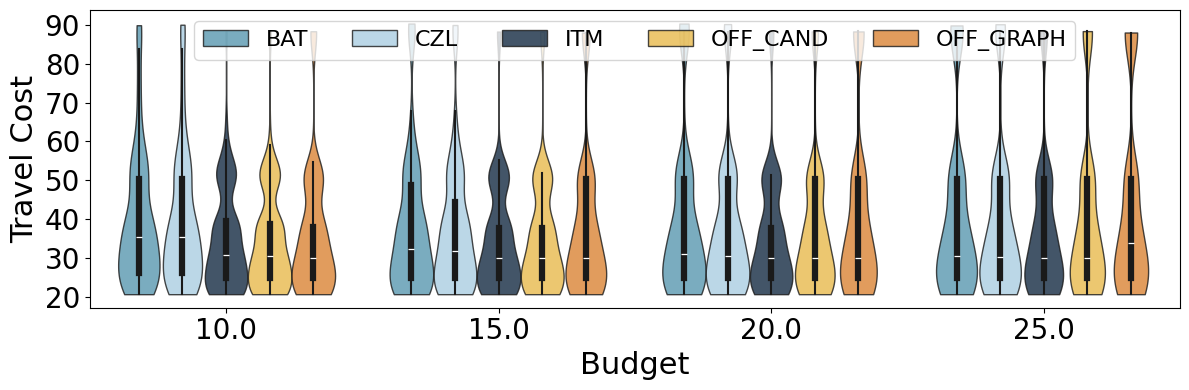

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


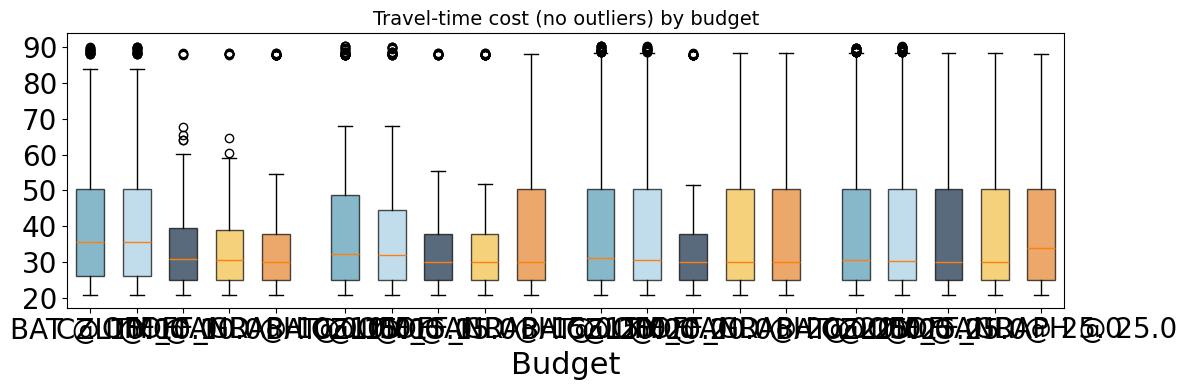

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


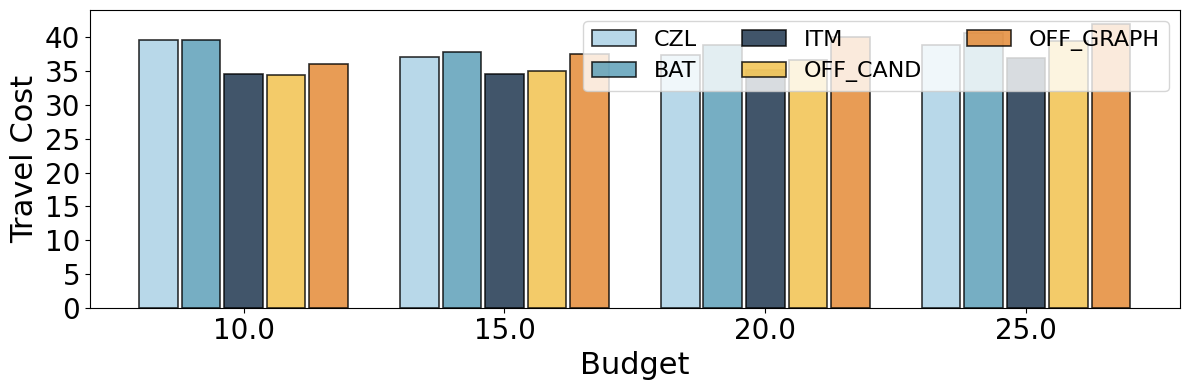

: 

: 

In [ ]:

# Remove outliers per algorithm using IQR (1.5x)
travel_no_outliers = remove_outliers_iqr(travel_df, 'travel_cost')

CURRENT_PLOT_SUBDIR = 'travel_no_outliers'
xlabel = 'Traffic Density Level'
violin_metric(travel_no_outliers, 'travel_cost', 'risk_level_display', 'algorithm', 'Travel-time cost (no outliers) by traffic density (violin)', xlabel=xlabel, save=True)
boxplot_metric(travel_no_outliers, 'travel_cost', 'risk_level_display', 'algorithm', 'Travel-time cost (no outliers) by traffic density', xlabel=xlabel, save=True)
bar_metric(travel_no_outliers, 'travel_cost', 'risk_level_display', 'algorithm', 'Mean travel-time cost (no outliers) by traffic density', xlabel=xlabel, save=True)

violin_metric(travel_no_outliers, 'travel_cost', 'budget', 'algorithm', 'Travel-time cost (no outliers) by budget (violin)', xlabel='Budget', save=True)
boxplot_metric(travel_no_outliers, 'travel_cost', 'budget', 'algorithm', 'Travel-time cost (no outliers) by budget', xlabel='Budget', save=True)
bar_metric(travel_no_outliers, 'travel_cost', 'budget', 'algorithm', 'Mean travel-time cost (no outliers) by budget', xlabel='Budget', save=True)


### Travel-time cost deltas vs offline graph opt

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


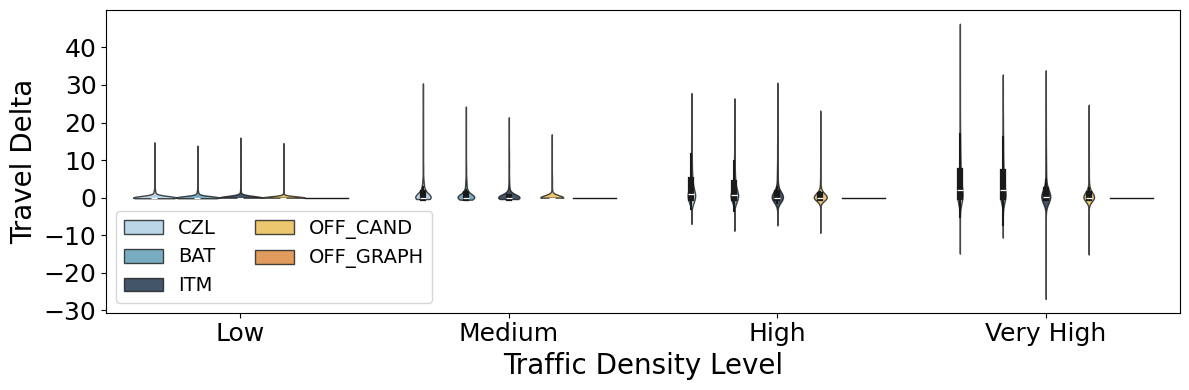

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


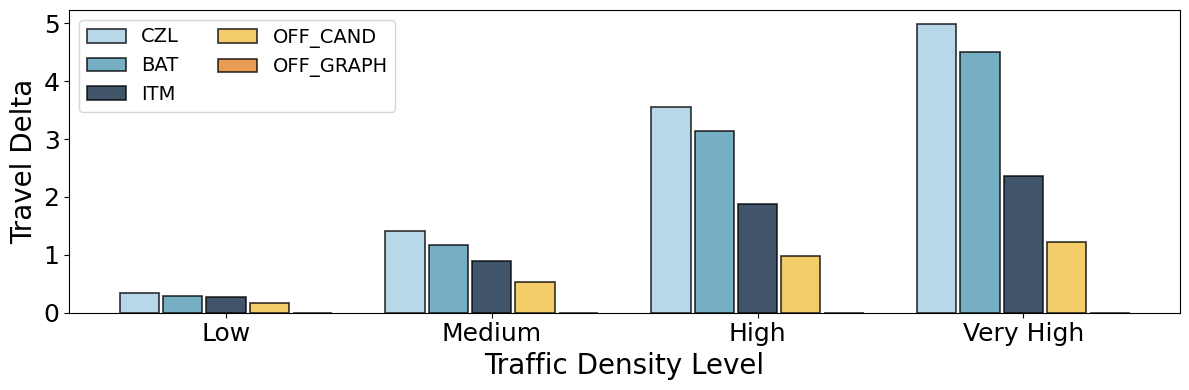

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


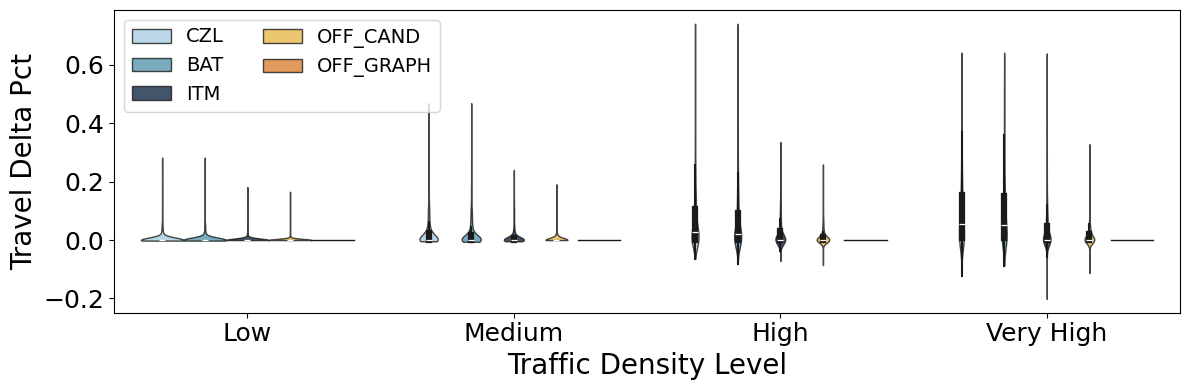

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


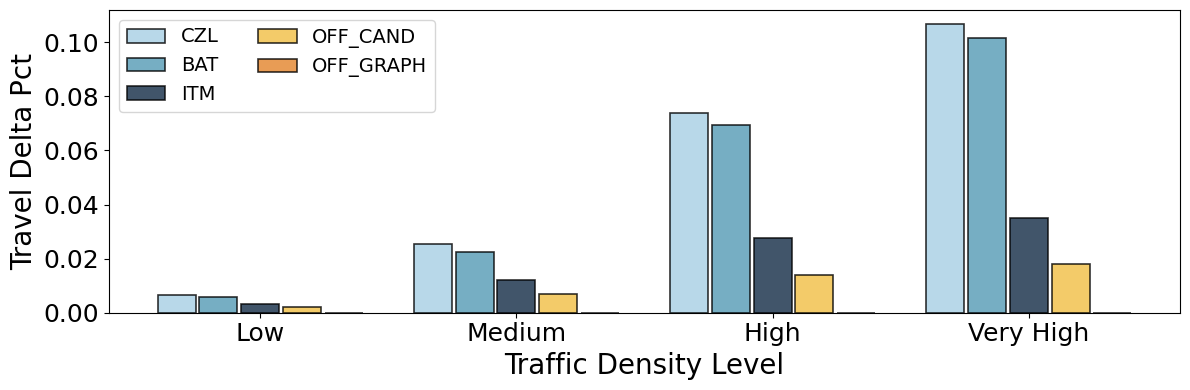

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


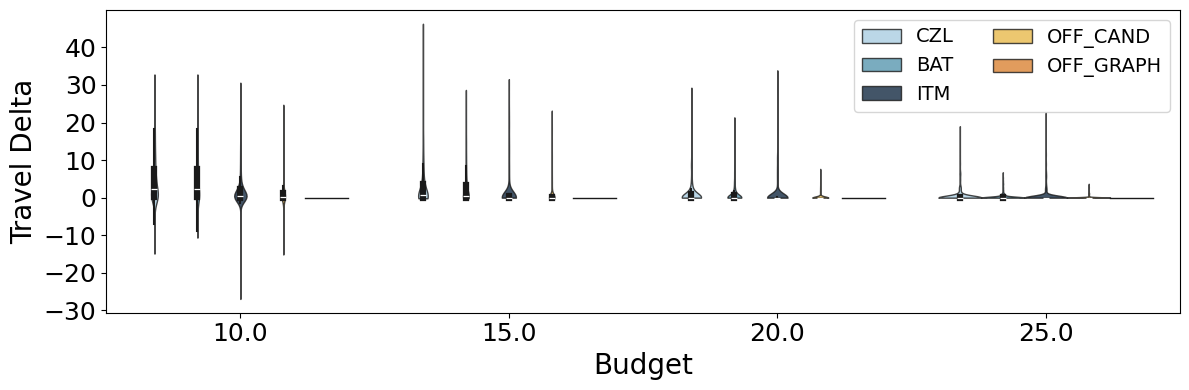

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


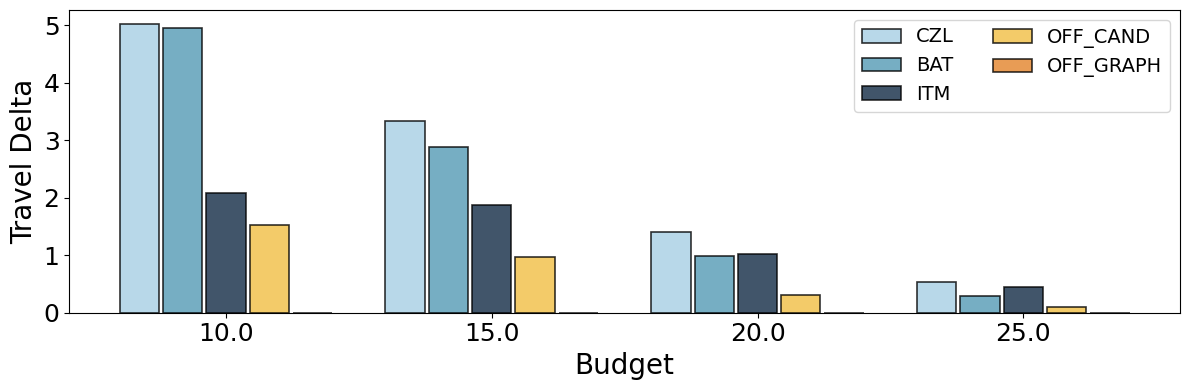

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


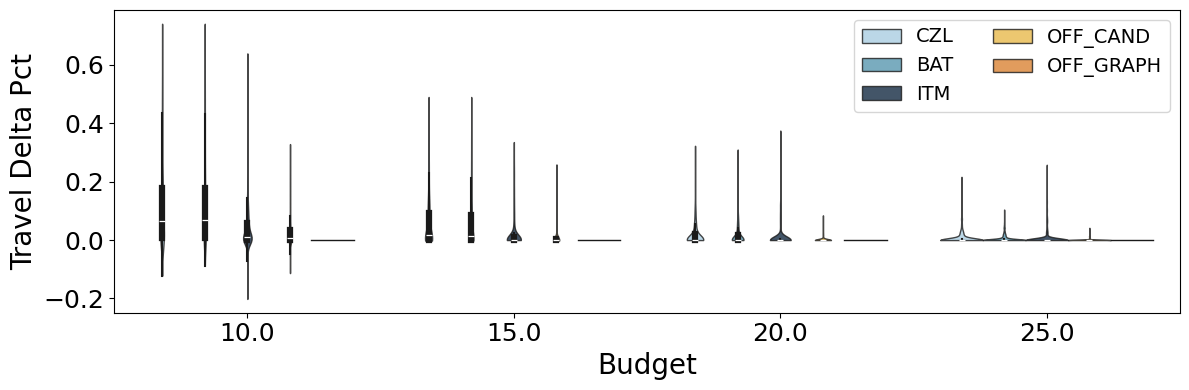

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


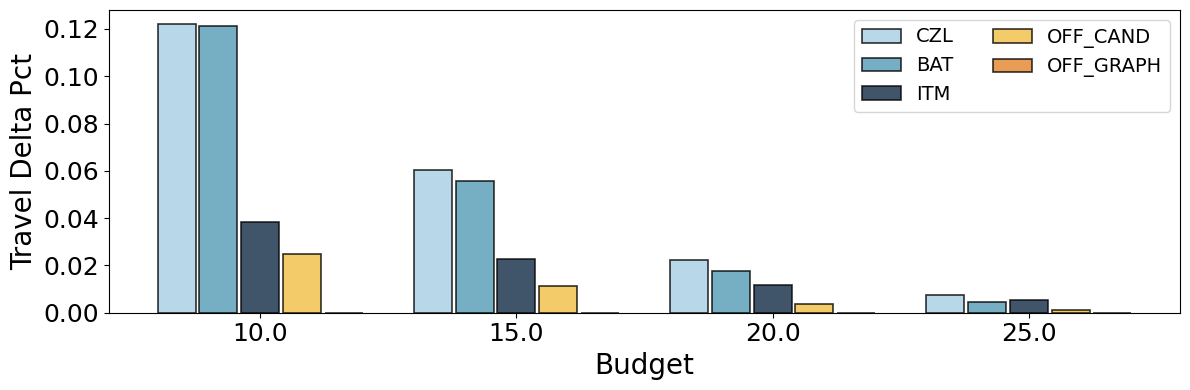

In [37]:

CURRENT_PLOT_SUBDIR = 'travel_delta'
xlabel = 'Traffic Density Level'
violin_metric(travel_delta_df, 'travel_delta', 'risk_level_display', 'algorithm', 'Travel-time cost delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True, legend_ncol=2)
# boxplot_metric(travel_delta_df, 'travel_delta', 'risk_level_display', 'algorithm', 'Travel-time cost delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)
bar_metric(travel_delta_df, 'travel_delta', 'risk_level_display', 'algorithm', 'Mean travel-time cost delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)

violin_metric(travel_delta_df, 'travel_delta_pct', 'risk_level_display', 'algorithm', 'Travel-time cost % delta vs offline graph by traffic density (violin)', xlabel=xlabel, save=True, legend_ncol=2)
# boxplot_metric(travel_delta_df, 'travel_delta_pct', 'risk_level_display', 'algorithm', 'Travel-time cost % delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)
bar_metric(travel_delta_df, 'travel_delta_pct', 'risk_level_display', 'algorithm', 'Mean travel-time cost % delta vs offline graph by traffic density', xlabel=xlabel, save=True, legend_ncol=2)

violin_metric(travel_delta_df, 'travel_delta', 'budget', 'algorithm', 'Travel-time cost delta vs offline graph by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
# boxplot_metric(travel_delta_df, 'travel_delta', 'budget', 'algorithm', 'Travel-time cost delta vs offline graph by budget', xlabel='Budget', save=True)
bar_metric(travel_delta_df, 'travel_delta', 'budget', 'algorithm', 'Mean travel-time cost delta vs offline graph by budget', xlabel='Budget', save=True, legend_ncol=2)

violin_metric(travel_delta_df, 'travel_delta_pct', 'budget', 'algorithm', 'Travel-time cost % delta vs offline graph by budget (violin)', xlabel='Budget', save=True, legend_ncol=2)
# boxplot_metric(travel_delta_df, 'travel_delta_pct', 'budget', 'algorithm', 'Travel-time cost % delta vs offline graph by budget', xlabel='Budget', save=True)
bar_metric(travel_delta_df, 'travel_delta_pct', 'budget', 'algorithm', 'Mean travel-time cost % delta vs offline graph by budget', xlabel='Budget', save=True, legend_ncol=2)


## Utility comparisons (risk level and budget)

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


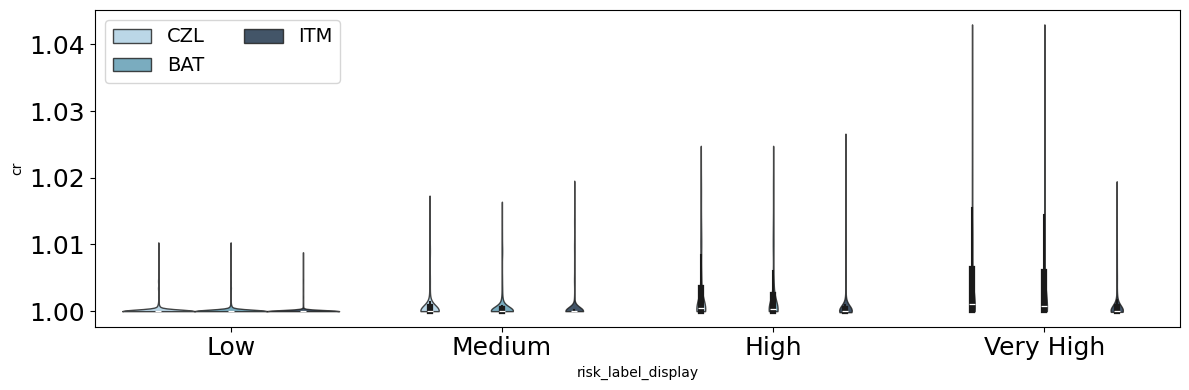

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


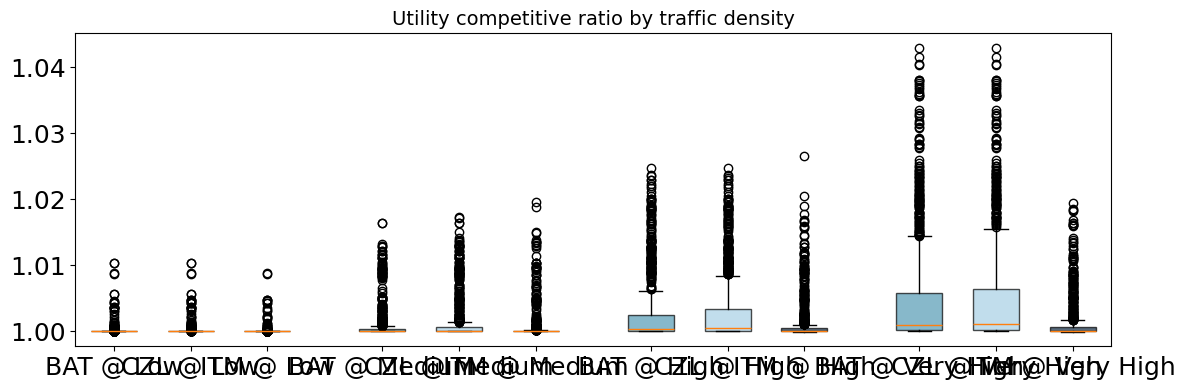

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


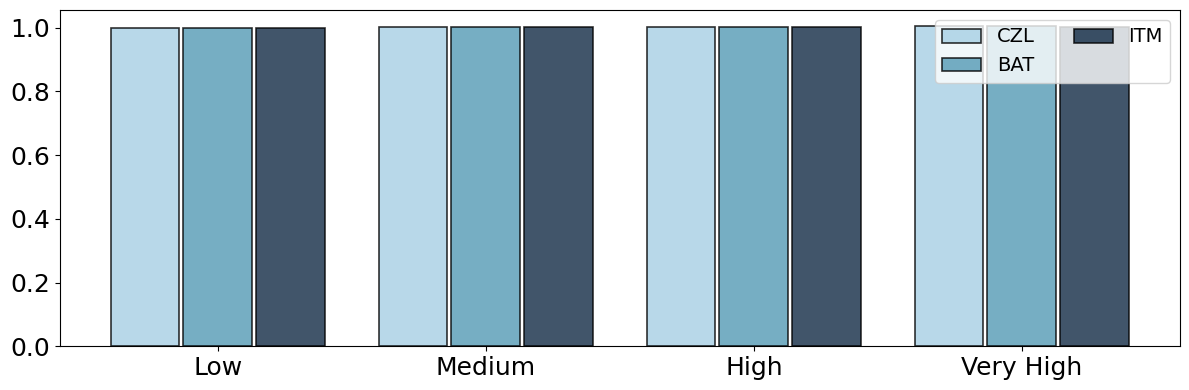

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


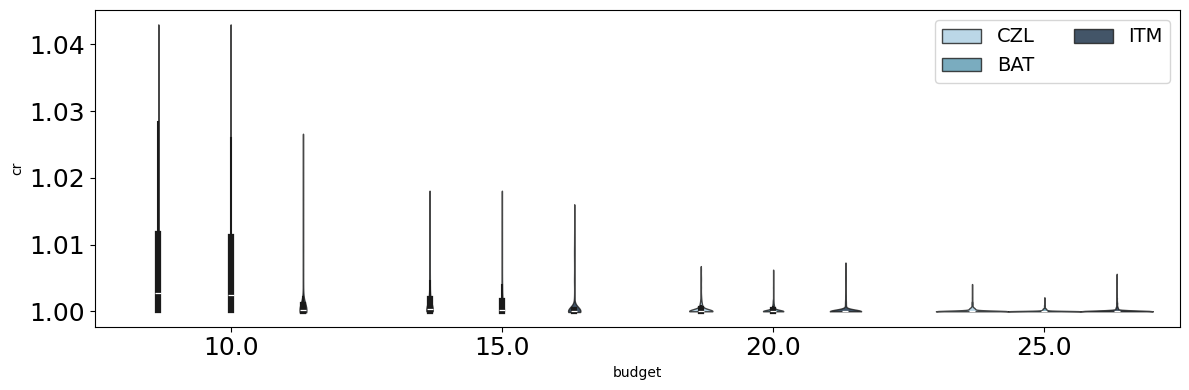

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


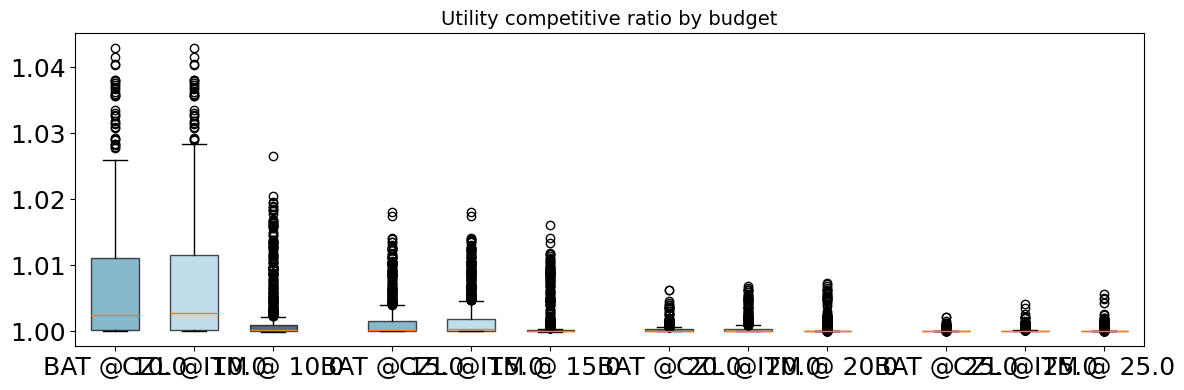

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


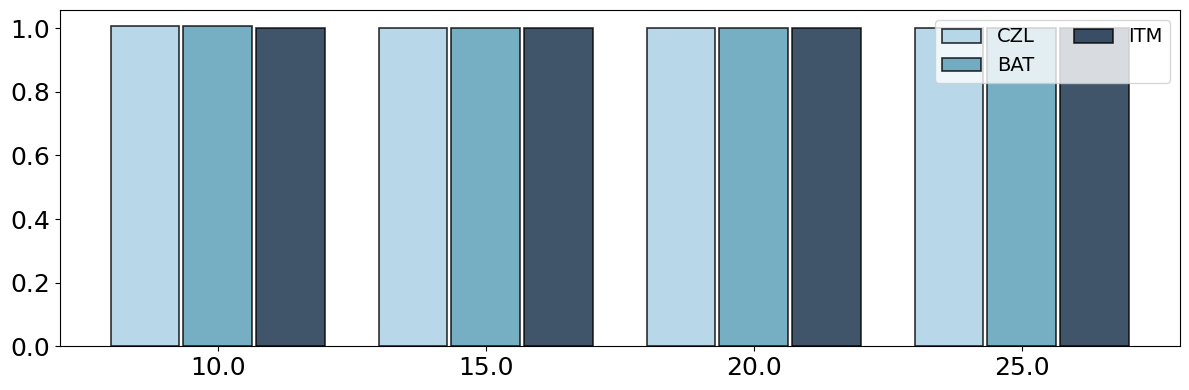

In [38]:

CURRENT_PLOT_SUBDIR = 'competitive_ratio'
# By risk label
violin_metric(long_cr_utility, 'cr', 'risk_label_display', 'algorithm', 'Utility competitive ratio by traffic density (violin)', save=True, legend_ncol=2)
boxplot_metric(long_cr_utility, 'cr', 'risk_label_display', 'algorithm', 'Utility competitive ratio by traffic density', save=True)
bar_metric(long_cr_utility, 'cr', 'risk_label_display', 'algorithm', 'Mean utility competitive ratio by traffic density', save=True, legend_ncol=2)

# By budget
violin_metric(long_cr_utility, 'cr', 'budget', 'algorithm', 'Utility competitive ratio by budget (violin)', save=True, legend_ncol=2)
boxplot_metric(long_cr_utility, 'cr', 'budget', 'algorithm', 'Utility competitive ratio by budget', save=True)
bar_metric(long_cr_utility, 'cr', 'budget', 'algorithm', 'Mean utility competitive ratio by budget', save=True, legend_ncol=2)


## Total cost comparisons (overall, lateral, travel)

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


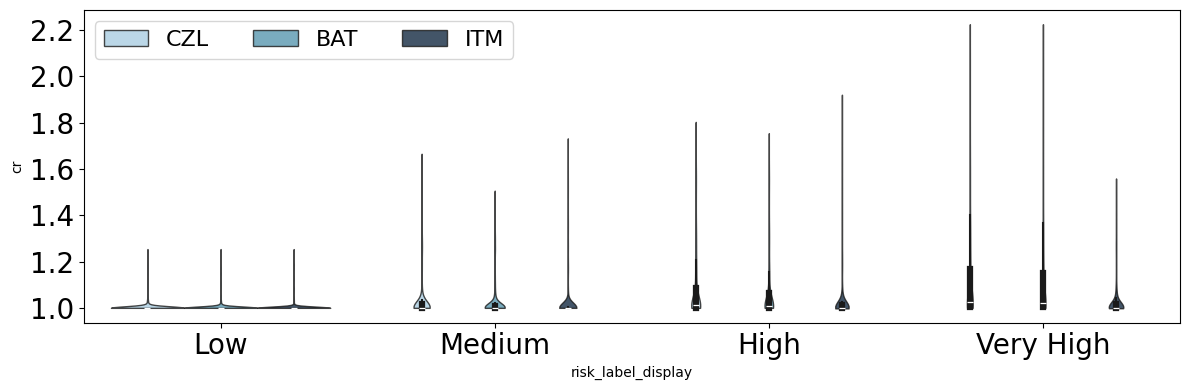

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


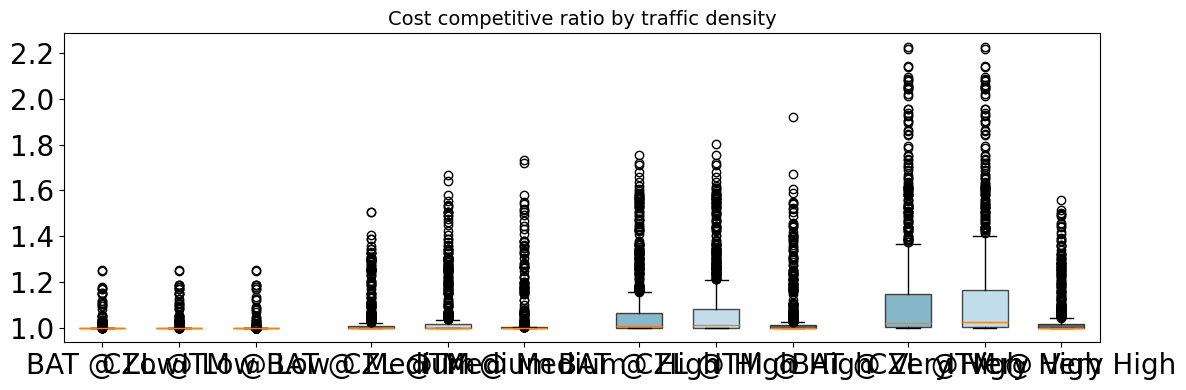

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_31183/1173993868.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


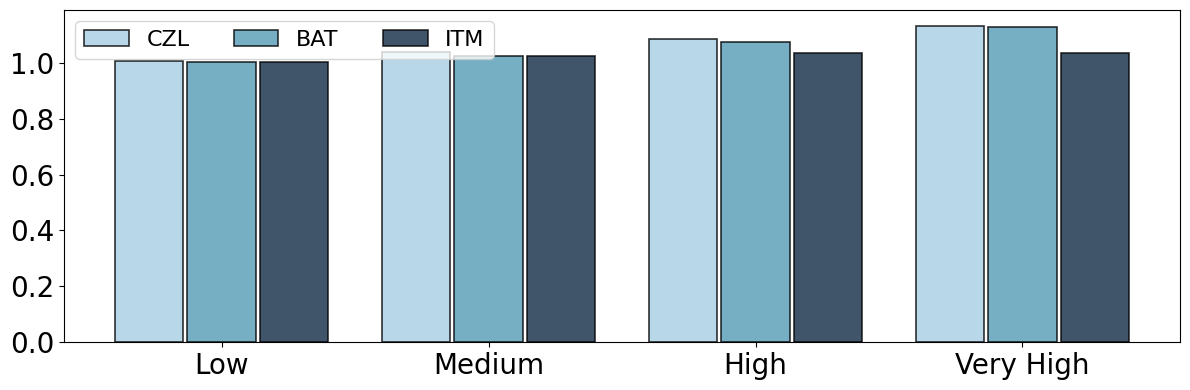

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


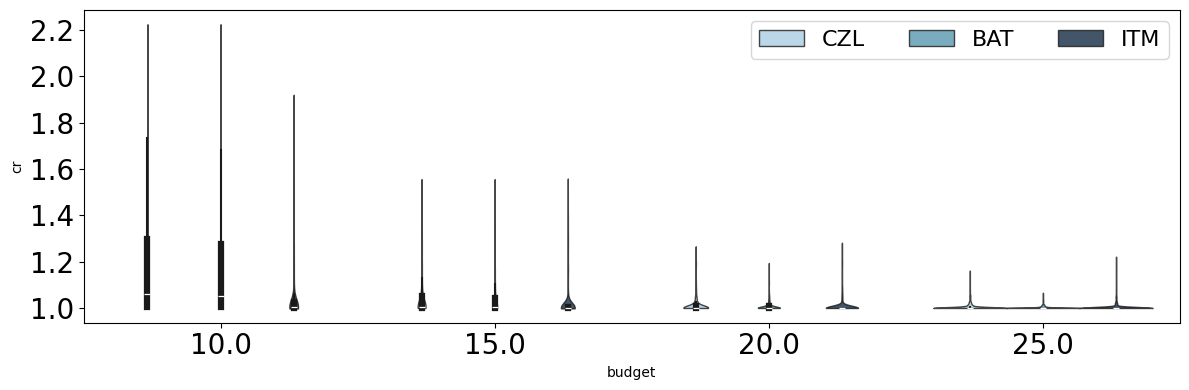

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


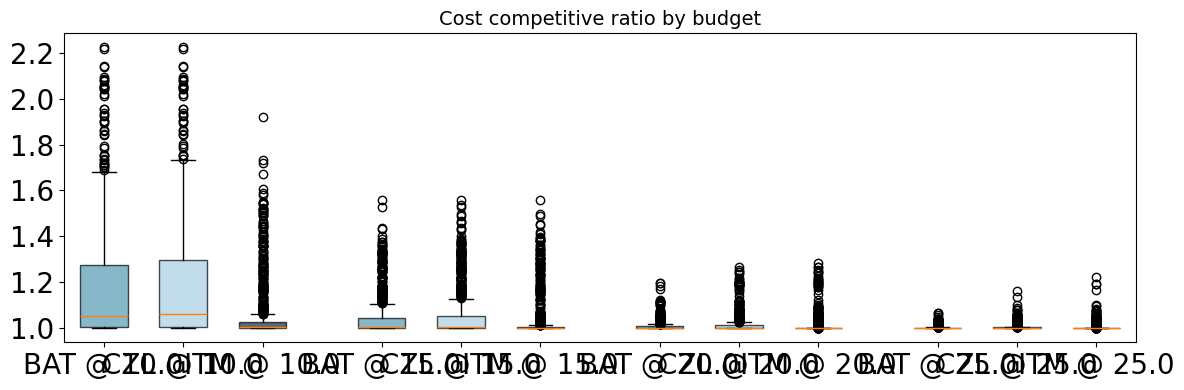

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


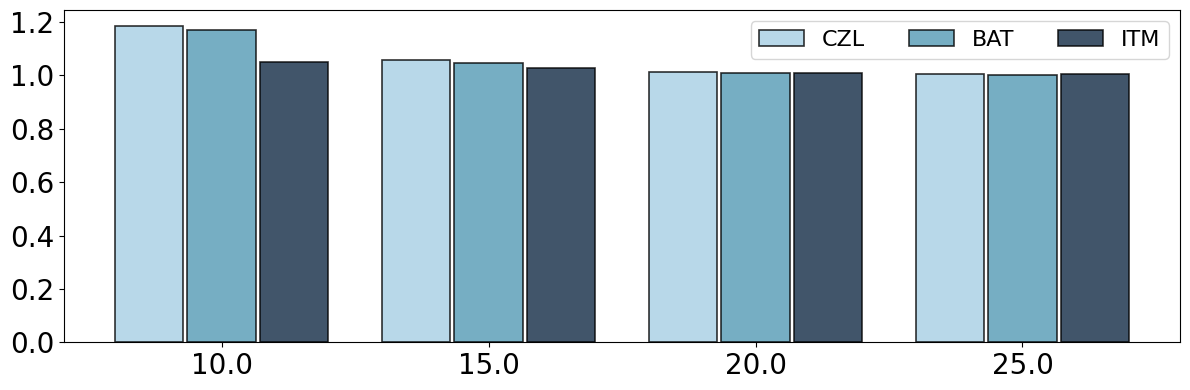

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


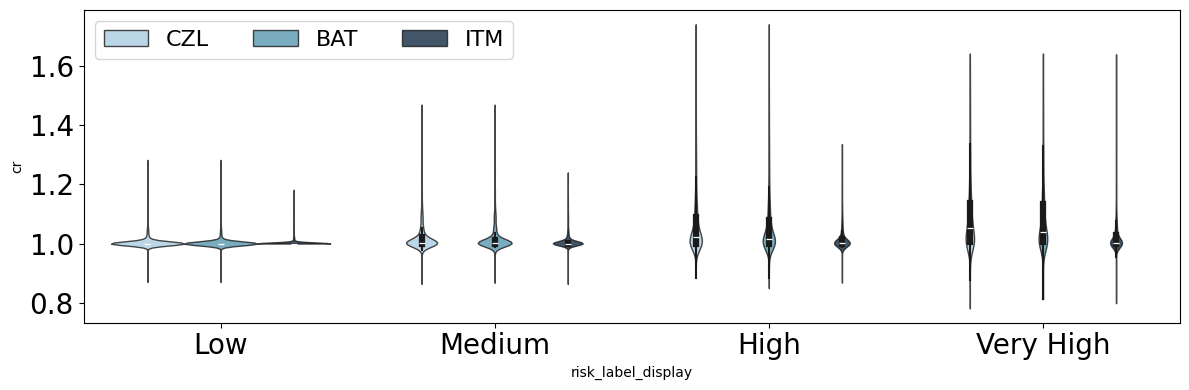

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


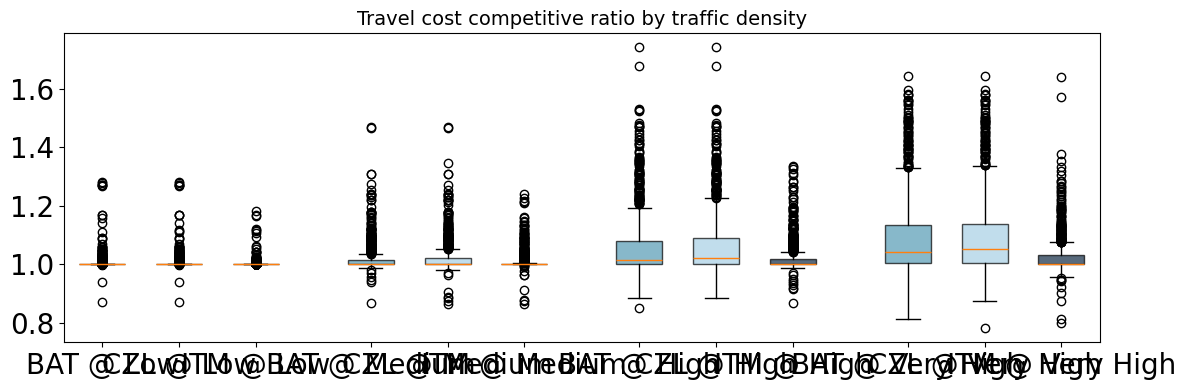

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_31183/1173993868.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


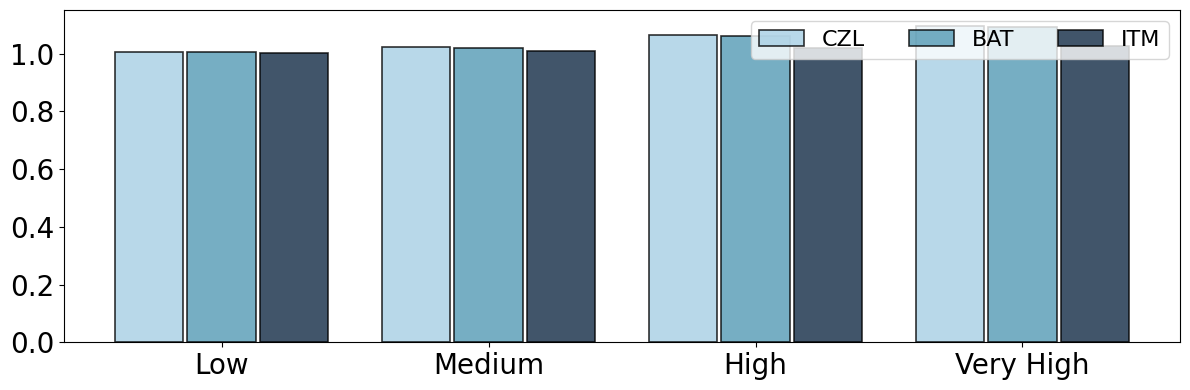

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


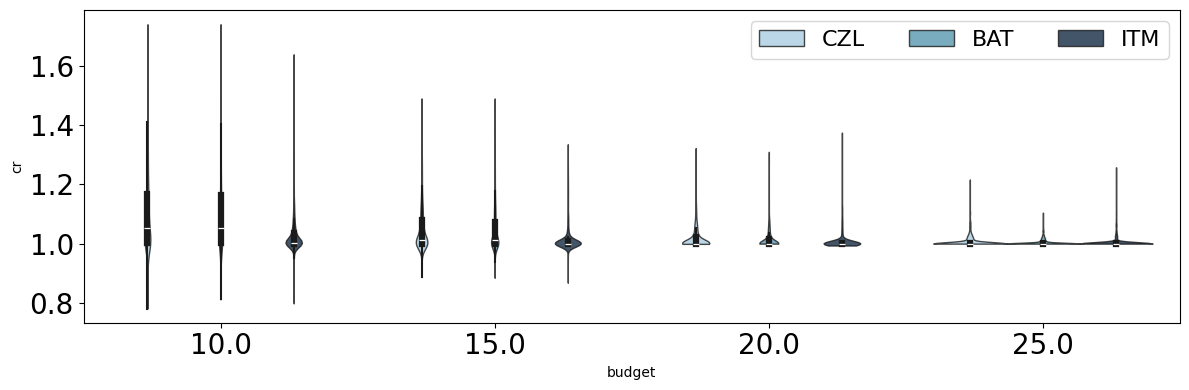

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


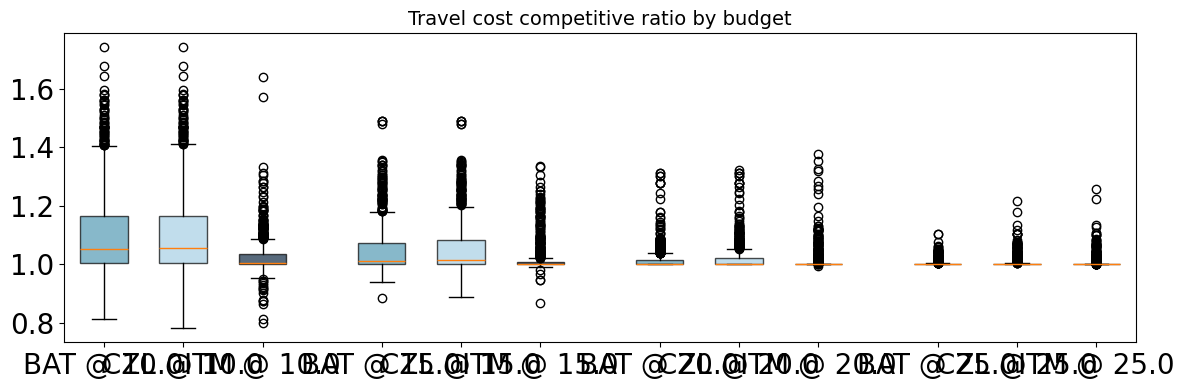

/tmp/ipykernel_31183/1173993868.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


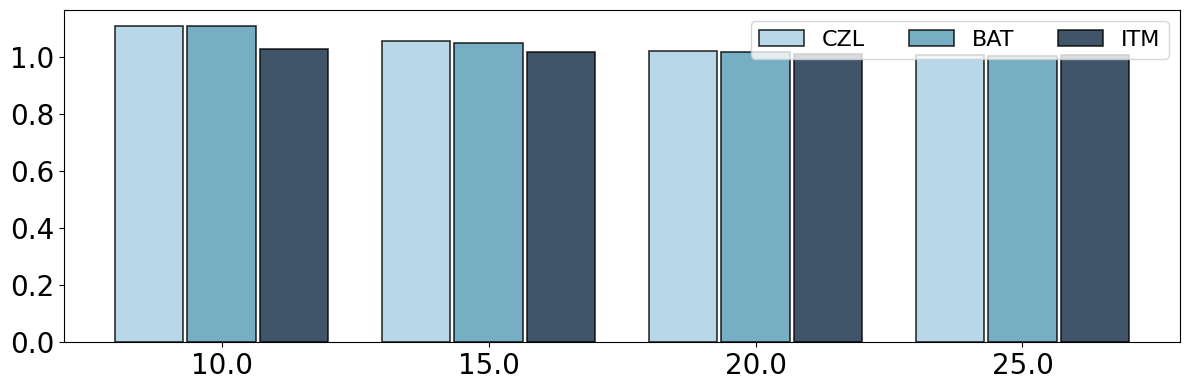

: 

: 

In [ ]:

CURRENT_PLOT_SUBDIR = 'competitive_ratio'
# Overall cost CR
violin_metric(long_cr_cost, 'cr', 'risk_label_display', 'algorithm', 'Cost competitive ratio by traffic density (violin)', save=True)
boxplot_metric(long_cr_cost, 'cr', 'risk_label_display', 'algorithm', 'Cost competitive ratio by traffic density', save=True)
bar_metric(long_cr_cost, 'cr', 'risk_label_display', 'algorithm', 'Mean cost competitive ratio by traffic density', save=True)

violin_metric(long_cr_cost, 'cr', 'budget', 'algorithm', 'Cost competitive ratio by budget (violin)', save=True)
boxplot_metric(long_cr_cost, 'cr', 'budget', 'algorithm', 'Cost competitive ratio by budget', save=True)
bar_metric(long_cr_cost, 'cr', 'budget', 'algorithm', 'Mean cost competitive ratio by budget', save=True)

# Travel-time cost CR
violin_metric(long_cr_travel, 'cr', 'risk_label_display', 'algorithm', 'Travel cost competitive ratio by traffic density (violin)', save=True)
boxplot_metric(long_cr_travel, 'cr', 'risk_label_display', 'algorithm', 'Travel cost competitive ratio by traffic density', save=True)
bar_metric(long_cr_travel, 'cr', 'risk_label_display', 'algorithm', 'Mean travel cost competitive ratio by traffic density', save=True)

violin_metric(long_cr_travel, 'cr', 'budget', 'algorithm', 'Travel cost competitive ratio by budget (violin)', save=True)
boxplot_metric(long_cr_travel, 'cr', 'budget', 'algorithm', 'Travel cost competitive ratio by budget', save=True)
bar_metric(long_cr_travel, 'cr', 'budget', 'algorithm', 'Mean travel cost competitive ratio by budget', save=True)


### Mean CR delta vs 1 (density/budget)

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


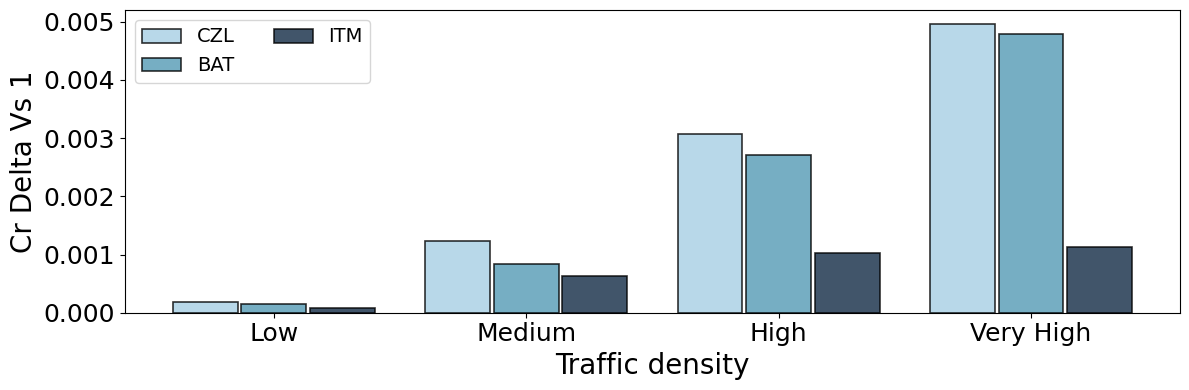

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


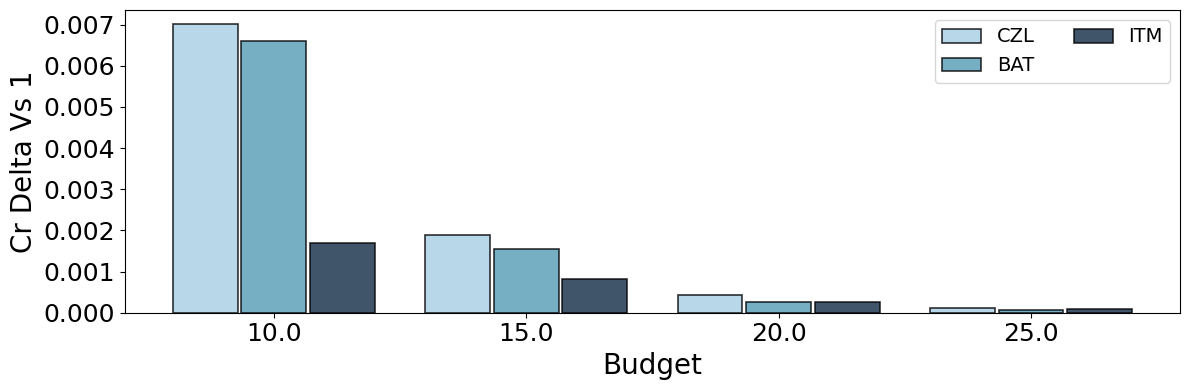

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/632713577.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


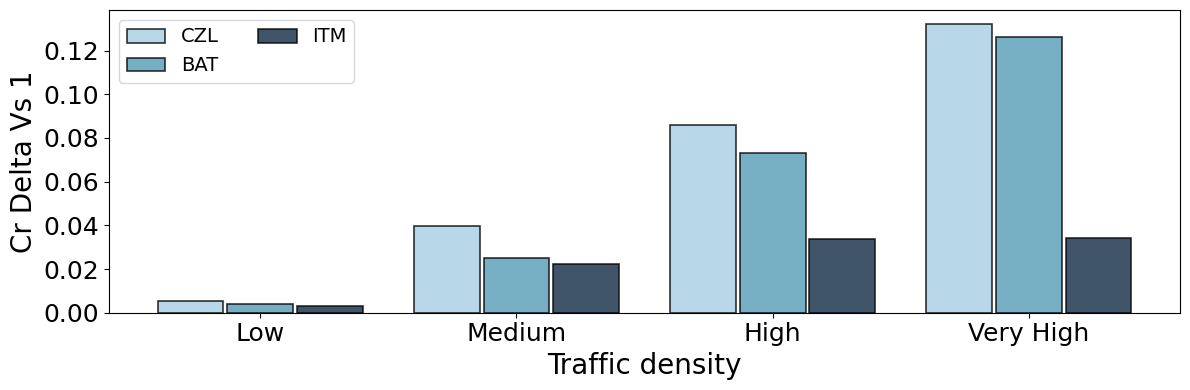

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


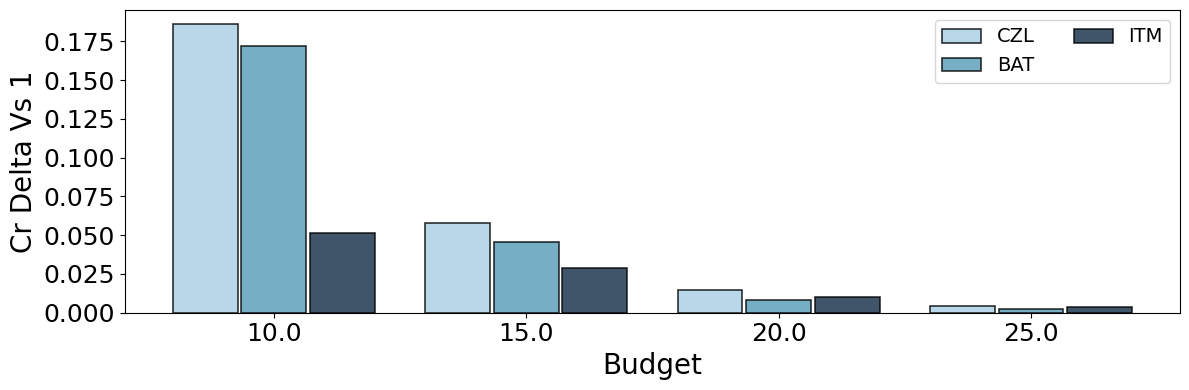

In [41]:

CURRENT_PLOT_SUBDIR = 'competitive_ratio_insights'

def _with_cr_delta_vs_1(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out['cr_delta_vs_1'] = out['cr'] - 1.0
    return out

util_delta = _with_cr_delta_vs_1(long_cr_utility)
cost_delta = _with_cr_delta_vs_1(long_cr_cost)

bar_metric(
    util_delta,
    'cr_delta_vs_1',
    'risk_label_display',
    'algorithm',
    'Utility CR delta vs 1 by traffic density',
    xlabel='Traffic density',
    save=True,
    filename='utility-cr-delta-vs-1-by-risk',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
)
bar_metric(
    util_delta,
    'cr_delta_vs_1',
    'budget',
    'algorithm',
    'Utility CR delta vs 1 by budget',
    xlabel='Budget',
    save=True,
    filename='utility-cr-delta-vs-1-by-budget',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
)

bar_metric(
    cost_delta,
    'cr_delta_vs_1',
    'risk_label_display',
    'algorithm',
    'Cost CR delta vs 1 by traffic density',
    xlabel='Traffic density',
    save=True,
    filename='cost-cr-delta-vs-1-by-risk',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
)
bar_metric(
    cost_delta,
    'cr_delta_vs_1',
    'budget',
    'algorithm',
    'Cost CR delta vs 1 by budget',
    xlabel='Budget',
    save=True,
    filename='cost-cr-delta-vs-1-by-budget',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
)


### Mean CR (y-axis starts at 1)

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/3586761861.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


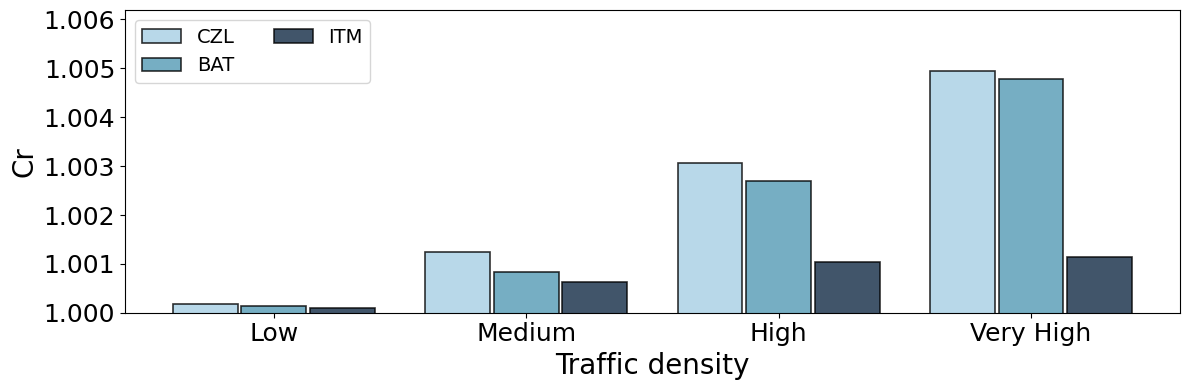

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


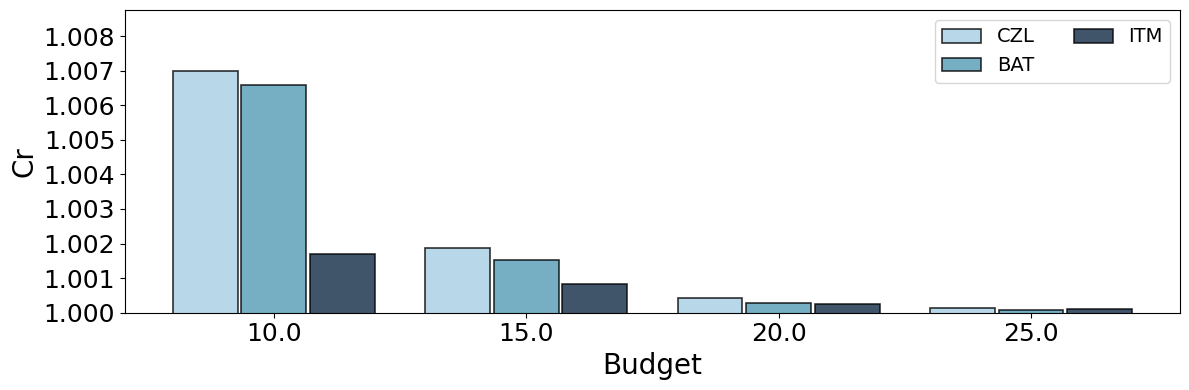

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):
/tmp/ipykernel_12121/3586761861.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()


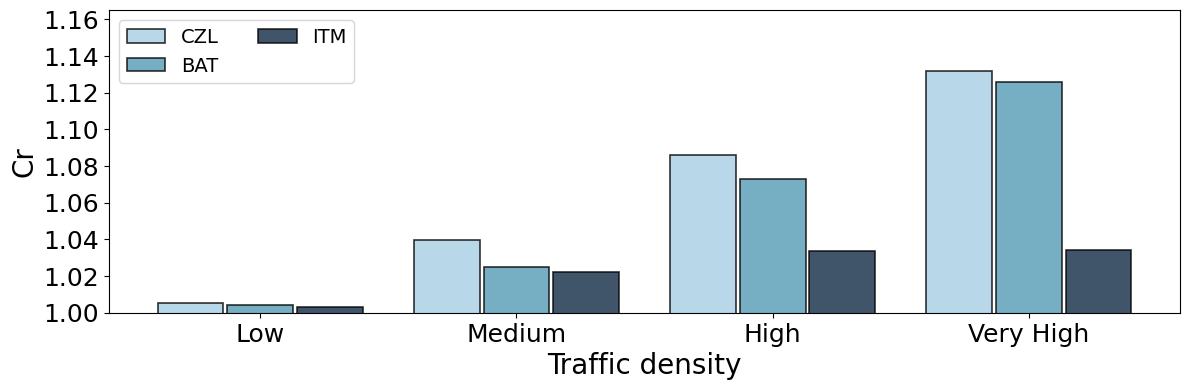

/tmp/ipykernel_12121/632713577.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(series):


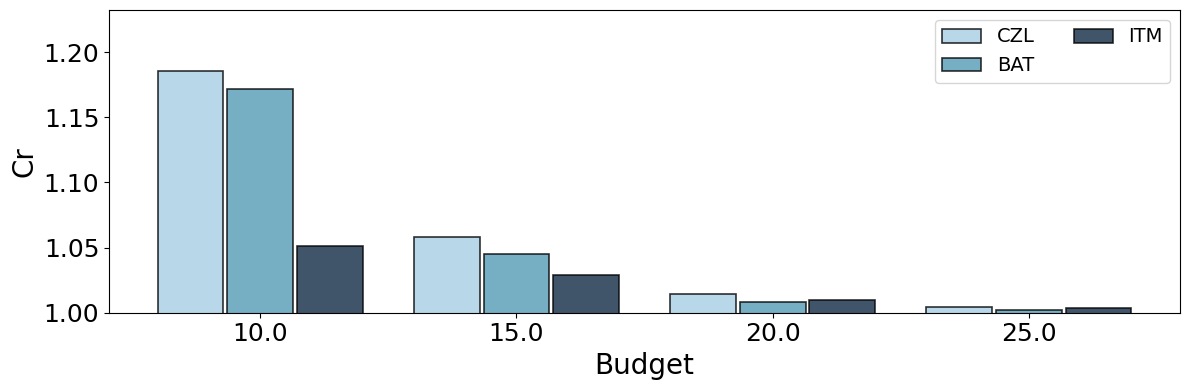

In [50]:

CURRENT_PLOT_SUBDIR = 'competitive_ratio_insights'

def bar_metric_with_ymin(
    df,
    value_col,
    group_col,
    hue_col,
    title,
    xlabel=None,
    save=False,
    filename=None,
    subdir=None,
    dpi=300,
    legend_ncol=3,
    y_min=1.0,
):
    if df.empty:
        print(f"{title}: no data")
        return
    hue_order_preference = ['CZL', 'BAT', 'ITM', 'OFF_CAND', 'OFF_GRAPH']
    group_order = _ordered_categories(df[group_col])
    grouped = df.groupby([group_col, hue_col])[value_col].mean().reset_index()
    hues_raw = [h for h in hue_order_preference if h in grouped[hue_col].unique()]
    if not hues_raw:
        hues_raw = sorted(grouped[hue_col].dropna().unique())
    group_gap = 0.0
    intra_gap = 0.015
    k = len(hues_raw)
    width = (0.8 - intra_gap * max(k - 1, 0)) / max(k, 1)
    x = np.arange(len(group_order)) * (1 + group_gap)
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(hues_raw):
        sub = grouped[grouped[hue_col] == h]
        vals = [sub[sub[group_col] == cat][value_col].mean() for cat in group_order]
        hatch = bar_hatches.get(h, '')
        offset = i * (width + intra_gap)
        plt.bar(
            x + offset,
            vals,
            width=width,
            label=h,
            color=palette.get(h, None),
            alpha=0.8,
            hatch=hatch,
            edgecolor='black',
            linewidth=1.2,
        )
    plt.xticks(x + (width * k + intra_gap * max(k - 1, 0) - width) / 2, group_order, rotation=0, fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
        plt.ylabel(value_col.replace('_', ' ').title(), fontsize=LABEL_FONTSIZE)
    plt.ylim(bottom=y_min,top=max(grouped[value_col])+(max(grouped[value_col])-1)/4)
    plt.legend(fontsize=LEGEND_FONTSIZE, ncol=legend_ncol, loc='best')
    plt.tight_layout()
    if save:
        _save_fig(plt.gcf(), filename or title, subdir=subdir, dpi=dpi)
    plt.show()

bar_metric_with_ymin(
    long_cr_utility,
    'cr',
    'risk_label_display',
    'algorithm',
    'Mean utility competitive ratio by traffic density (y>=1)',
    xlabel='Traffic density',
    save=True,
    filename='mean-utility-cr-by-risk-ymin-1',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
    y_min=1.0,
)
bar_metric_with_ymin(
    long_cr_utility,
    'cr',
    'budget',
    'algorithm',
    'Mean utility competitive ratio by budget (y>=1)',
    xlabel='Budget',
    save=True,
    filename='mean-utility-cr-by-budget-ymin-1',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
    y_min=1.0,
)

bar_metric_with_ymin(
    long_cr_cost,
    'cr',
    'risk_label_display',
    'algorithm',
    'Mean cost competitive ratio by traffic density (y>=1)',
    xlabel='Traffic density',
    save=True,
    filename='mean-cost-cr-by-risk-ymin-1',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
    y_min=1.0,
)
bar_metric_with_ymin(
    long_cr_cost,
    'cr',
    'budget',
    'algorithm',
    'Mean cost competitive ratio by budget (y>=1)',
    xlabel='Budget',
    save=True,
    filename='mean-cost-cr-by-budget-ymin-1',
    subdir=CURRENT_PLOT_SUBDIR,
    legend_ncol=2,
    y_min=1.0,
)


## Competitive ratio enhancements (zero-centered, ECDF, win map)

In [39]:

# Helper: ECDF plot with styled lines
def ecdf_plot(df, value_col, hue_col, title, xlabel=None, subdir=None):
    if df.empty:
        print(f'{title}: no data')
        return
    plot_df = df.dropna(subset=[value_col, hue_col])
    if plot_df.empty:
        print(f'{title}: no data after filtering')
        return
    plt.figure(figsize=(8, 5))
    style_map = {
        'CZL': {'linestyle': '-', 'marker': None, 'markersize': 1},
        'BAT': {'linestyle': '--', 'marker': None},
        'ITM': {'linestyle': '-.', 'marker': None},
    }
    for alg, sub in plot_df.groupby(hue_col):
        style = style_map.get(alg, {'linestyle': '-', 'marker': None, 'markersize': 5})
        sns.ecdfplot(
            data=sub,
            x=value_col,
            label=alg,
            lw=2.5,
            linestyle=style.get('linestyle', '-'),
            marker=style.get('marker'),
            markersize=style.get('markersize', 5),
            palette=palette,
            color=palette.get(alg)
        )
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    plt.title(title, fontsize=TITLE_FONTSIZE)
    plt.legend(fontsize=LEGEND_FONTSIZE)
    plt.xticks(fontsize=TICK_FONTSIZE); plt.yticks(fontsize=TICK_FONTSIZE); plt.tight_layout()
    _save_fig(plt.gcf(), title, subdir=subdir or CURRENT_PLOT_SUBDIR)
    plt.show()

# ECDF with cutoffs and bootstrap CIs

def ecdf_plot_with_ci(df, value_col, hue_col, title, xlabel=None, subdir=None, cutoffs=(1.0, 1.1, 1.2), n_boot=200, grid_size=200):
    if df.empty:
        print(f'{title}: no data')
        return
    plot_df = df.dropna(subset=[value_col, hue_col])
    if plot_df.empty:
        print(f'{title}: no data after filtering')
        return
    plt.figure(figsize=(8, 5))
    style_map = {
        'CZL': {'linestyle': 'dashed', 'marker': None},
        'BAT': {'linestyle': 'dotted', 'marker': None},
        'ITM': {'linestyle': '-', 'marker': None},
    }
    for alg, sub in plot_df.groupby(hue_col):
        vals = sub[value_col].dropna().to_numpy()
        if len(vals) == 0:
            continue
        xs = np.sort(vals)
        ys = np.arange(1, len(xs) + 1) / len(xs)
        style = style_map.get(alg, {'linestyle': '-'})
        plt.plot(xs, ys, label=alg, lw=2.5, linestyle=style.get('linestyle', '-'), color=palette.get(alg))
        # bootstrap CI
        grid = np.linspace(xs.min(), xs.max(), grid_size)
        boot = []
        for _ in range(n_boot):
            sample = np.random.choice(vals, size=len(vals), replace=True)
            s_sorted = np.sort(sample)
            ecdf = np.searchsorted(s_sorted, grid, side='right') / len(sample)
            boot.append(ecdf)
        if boot:
            boot = np.vstack(boot)
            lo, hi = np.quantile(boot, [0.05, 0.95], axis=0)
            # plt.fill_between(grid, lo, hi, color=palette.get(alg, '#888'), alpha=0.15, linewidth=5)
    # cutoff lines and annotations
    # for c in cutoffs:
    #     plt.axvline(c, color='#666666', linestyle=':', linewidth=1.2)
    #     for alg, sub in plot_df.groupby(hue_col):
    #         vals = sub[value_col].dropna()
    #         if len(vals)==0:
    #             continue
    #         share = (vals <= c).mean()
    #         plt.text(c, share, f"{alg}: {share:.2f}", fontsize=8, color=palette.get(alg), ha='left', va='bottom', rotation=90)
    if xlabel:
        plt.xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    plt.ylabel('ECDF', fontsize=LABEL_FONTSIZE)
    plt.title(title, fontsize=TITLE_FONTSIZE)
    plt.legend(fontsize=LEGEND_FONTSIZE, ncol=5)
    plt.xticks(fontsize=TICK_FONTSIZE); plt.yticks(fontsize=TICK_FONTSIZE); plt.tight_layout()
    _save_fig(plt.gcf(), title, subdir=subdir or CURRENT_PLOT_SUBDIR)
    plt.show()


: 

: 

### ECDF with cutoffs and confidence shading

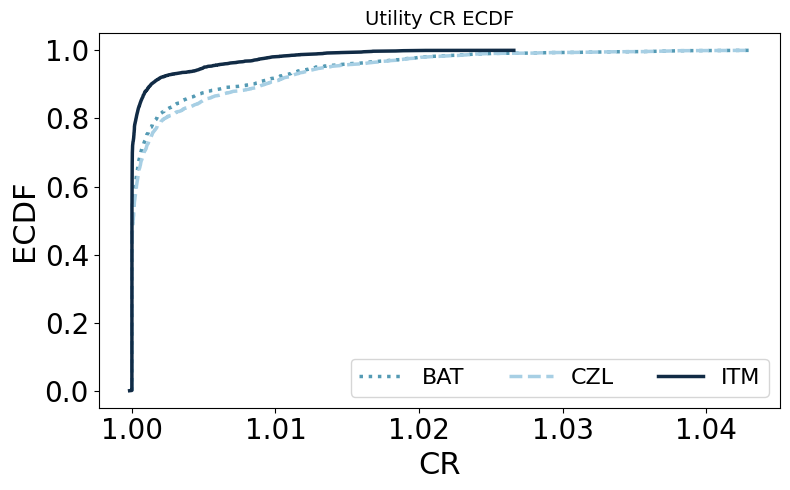

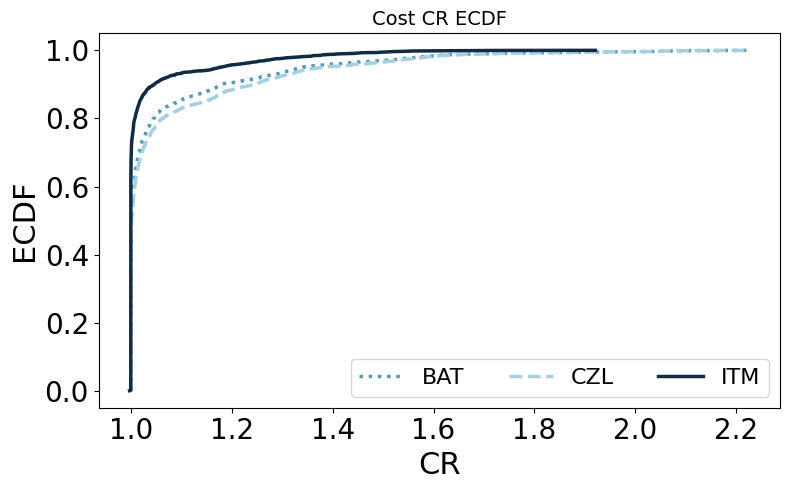

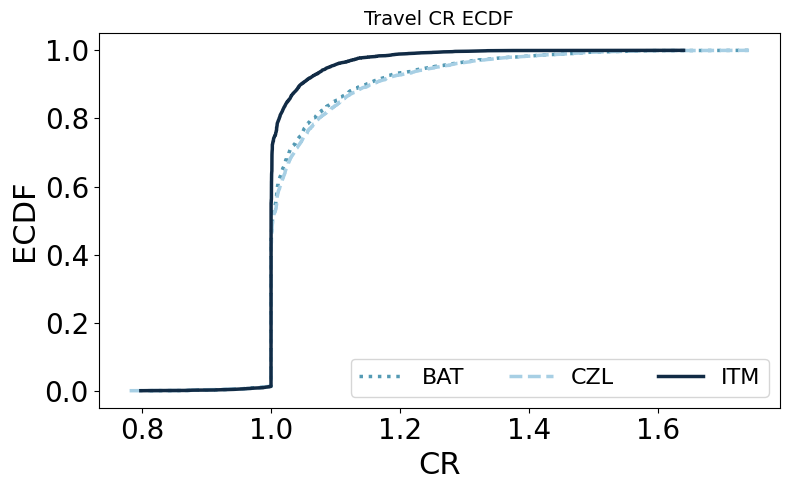

: 

: 

In [ ]:

CURRENT_PLOT_SUBDIR = 'competitive_ratio_ecdf_ci'
cutoffs = (1.0, 1.1, 1.2)
# ecdf_plot(long_cr_utility, 'cr', 'algorithm', 'Utility CR ECDF', xlabel='CR', subdir=CURRENT_PLOT_SUBDIR)
ecdf_plot_with_ci(long_cr_utility, 'cr', 'algorithm', 'Utility CR ECDF', xlabel='CR', subdir=CURRENT_PLOT_SUBDIR, cutoffs=cutoffs)
ecdf_plot_with_ci(long_cr_cost, 'cr', 'algorithm', 'Cost CR ECDF', xlabel='CR', subdir=CURRENT_PLOT_SUBDIR, cutoffs=cutoffs)
ecdf_plot_with_ci(long_cr_travel, 'cr', 'algorithm', 'Travel CR ECDF', xlabel='CR', subdir=CURRENT_PLOT_SUBDIR, cutoffs=cutoffs)


## Derived cost components (travel vs lateral totals)

In [40]:

# Summaries of derived costs per algorithm
lateral_records, travel_records = [], []
for prefix, label in [('online_czl', 'CZL'), ('online_bat', 'BAT'), ('online_itm', 'ITM'), ('offline_cand', 'OFF_CAND'), ('offline_graph', 'OFF_GRAPH')]:
    lat_col, trav_col = f'{prefix}.lateral_cost', f'{prefix}.travel_cost'
    if lat_col in df_cr.columns:
        lateral_records.append({'algorithm': label, 'mean_lateral': df_cr[lat_col].dropna().mean(), 'median_lateral': df_cr[lat_col].dropna().median()})
    if trav_col in df_cr.columns:
        travel_records.append({'algorithm': label, 'mean_travel': df_cr[trav_col].dropna().mean(), 'median_travel': df_cr[trav_col].dropna().median()})

print('Lateral cost summary:')
display(pd.DataFrame(lateral_records))
print('Travel cost summary:')
display(pd.DataFrame(travel_records))


Lateral cost summary:


algorithm  mean_lateral  median_lateral
0        CZL     64.208333            50.0
1        BAT     63.395833            50.0
2        ITM     61.770833            50.0
3   OFF_CAND     60.229167            50.0
4  OFF_GRAPH     59.333333            50.0

Travel cost summary:


algorithm  mean_travel  median_travel
0        CZL    45.245189      37.729183
1        BAT    44.948581      37.729183
2        ITM    44.027321      37.729183
3   OFF_CAND    43.398770      37.729183
4  OFF_GRAPH    42.673927      34.615855